# CHEERS HG19 Calderon et al.

**Created**: 3 March 2022

I ran CHEERS on the following set of SNPs. In all cases, I included the SNPs and any tagging SNPs ($R^2 > 0.8$).

1. Lead eSNPs from Initial cis-eQTL Mapping
2. Conditional eSNPs from cis-eQTL Mapping
3. Lead eSNPs that are sepsis-specific based on Katie's mashR analysis
4. Lead eSNPs that are sepsis-specific and stronger in GAInS based on Katie's mashR analysis

## Environment

In [255]:
if (!requireNamespace("patchwork")) {
    install.packages("devtools")
    devtools::install_github("thomasp85/patchwork")
}

if (!requireNamespace("ComplexHeatmap", quietly=TRUE)) {
    BiocManager::install("ComplexHeatmap")
}

if (!requireNamespace("magick", quietly=TRUE)) {
    install.packages("magick")
}

Warning message in install.packages("magick"):
“installation of package ‘magick’ had non-zero exit status”


In [133]:
library(tidyverse)
library(patchwork)
library(ComplexHeatmap)
library(data.table)

setwd("~/eQTL_pQTL_Characterization/")

source("03_Functional_Interpretation/scripts/utils/ggplot_theme.R")

Loading required package: grid

ComplexHeatmap version 2.6.2
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))
! pheatmap() has been masked by ComplexHeatmap::pheatmap(). 90% of the arguments
   in the original pheatmap() are identically supported in the new function. You 
   can still use the original function by explicitly calling pheatmap::pheatmap().



Attaching package: ‘ComplexHeatmap’


The following object is masked from ‘package:pheatmap’:

    pheatmap




## All Cell Conditions

### Load Data

In [3]:
lead.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/lead_snps_disease_enrichment_observedMeanRank.txt", 
    col.names=c("Condition", "Rank.Mean")
)
conditional.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_snps_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)
conditional.secondary.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_secondary_snps_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)
non.sepsis.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/non_sepsis_snps_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)
sepsis.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_snps_disease_enrichment_observedMeanRank.txt", 
    col.names=c("Condition", "Rank.Mean")
)
sepsis.up.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_up_snps_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)

In [4]:
lead.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/lead_snps_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
conditional.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_snps_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
conditional.secondary.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_secondary_snps_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
non.sepsis.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/non_sepsis_snps_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
sepsis.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_snps_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
sepsis.up.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_up_snps_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))

In [5]:
lead.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/lead_snps.log", sep="\t")
conditional.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_snps.log", sep="\t")
conditional.secondary.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_secondary_snps.log", sep="\t")
non.sepsis.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/non_sepsis_snps.log", sep="\t")
sepsis.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_snps.log", sep="\t")
sepsis.up.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_up_snps.log", sep="\t")

In [6]:
lineages <- read.csv("03_Functional_Interpretation/data/Calderon_et_al_lineages.csv")

In [7]:
head(lineages)

,Lineage,Cell_Type
,<chr>,<chr>
1,B,Bulk_B
2,B,Mem_B
3,B,Naive_B
4,B,Plasmoblasts
5,CD8,CD8pos_T
6,CD8,Central_memory_CD8pos_T


The Bonferroni-adjusted significance is adjusted based on the number of samples tested against (`nrow(lead.p.vals)`), the number of SNP lists tested (6), and the number of times the testing is done (2).

In [8]:
critical.value <- qnorm(0.05 / (nrow(lead.p.vals) * 6 * 2), lower.tail=F)

In [9]:
stat.info <- data.frame(
    SNPs=c("Lead cis-eQTL", "Conditional cis-eQTL", "Conditional Secondary cis-eQTL", "Non-Sepsis-Specific cis-eQTL", "Sepsis-Specific cis-eQTL", "Sepsis-Specific Up cis-eQTL"),
    Mean=c(lead.summary[4,2], conditional.summary[4,2], conditional.secondary.summary[4,2], non.sepsis.summary[4,2], sepsis.summary[4,2], sepsis.up.summary[4,2]),
    SD=c(lead.summary[5,2], conditional.summary[5,2], conditional.secondary.summary[5,2], non.sepsis.summary[5,2], sepsis.summary[5,2], sepsis.up.summary[5,2])
)

head(stat.info)

,SNPs,Mean,SD
,<chr>,<dbl>,<dbl>
1,Lead cis-eQTL,361495.5,1071.1629
2,Conditional cis-eQTL,361495.5,962.4884
3,Conditional Secondary cis-eQTL,361495.5,1669.0330
4,Non-Sepsis-Specific cis-eQTL,361495.5,1166.6469
5,Sepsis-Specific cis-eQTL,361495.5,2068.6600
6,Sepsis-Specific Up cis-eQTL,361495.5,3351.4886


In [10]:
effects <- dplyr::bind_rows(
    lead.effects %>% dplyr::mutate(SNPs="Lead cis-eQTL"),
    conditional.effects %>% dplyr::mutate(SNPs="Conditional cis-eQTL"),
    conditional.secondary.effects %>% dplyr::mutate(SNPs="Conditional Secondary cis-eQTL"),
    non.sepsis.effects %>% dplyr::mutate(SNPs="Non-Sepsis-Specific cis-eQTL"),
    sepsis.effects %>% dplyr::mutate(SNPs="Sepsis-Specific cis-eQTL"),
    sepsis.up.effects %>% dplyr::mutate(SNPs="Sepsis-Specific Up cis-eQTL")
)

head(effects)

,Condition,Rank.Mean,SNPs
,<chr>,<dbl>,<chr>
1,Bulk_B-S,283664.3,Lead cis-eQTL
2,Bulk_B-U,359175.7,Lead cis-eQTL
3,CD8pos_T-S,303142.9,Lead cis-eQTL
4,CD8pos_T-U,397980.3,Lead cis-eQTL
5,Central_memory_CD8pos_T-S,314270.4,Lead cis-eQTL
6,Central_memory_CD8pos_T-U,391481.2,Lead cis-eQTL


In [11]:
p.vals <- dplyr::bind_rows(
    lead.p.vals %>% dplyr::mutate(SNPs="Lead cis-eQTL"),
    conditional.p.vals %>% dplyr::mutate(SNPs="Conditional cis-eQTL"),
    conditional.secondary.p.vals %>% dplyr::mutate(SNPs="Conditional Secondary cis-eQTL"),
    non.sepsis.p.vals %>% dplyr::mutate(SNPs="Non-Sepsis-Specific cis-eQTL"),
    sepsis.p.vals %>% dplyr::mutate(SNPs="Sepsis-Specific cis-eQTL"),
    sepsis.up.p.vals %>% dplyr::mutate(SNPs="Sepsis-Specific Up cis-eQTL")
)

head(p.vals)

,Condition,P.Value,SNPs
,<chr>,<dbl>,<chr>
1,Bulk_B-S,1.0000000,Lead cis-eQTL
2,Bulk_B-U,0.9848306,Lead cis-eQTL
3,CD8pos_T-S,1.0000000,Lead cis-eQTL
4,CD8pos_T-U,0.0000000,Lead cis-eQTL
5,Central_memory_CD8pos_T-S,1.0000000,Lead cis-eQTL
6,Central_memory_CD8pos_T-U,0.0000000,Lead cis-eQTL


### Enrichment of Different SNP Lists

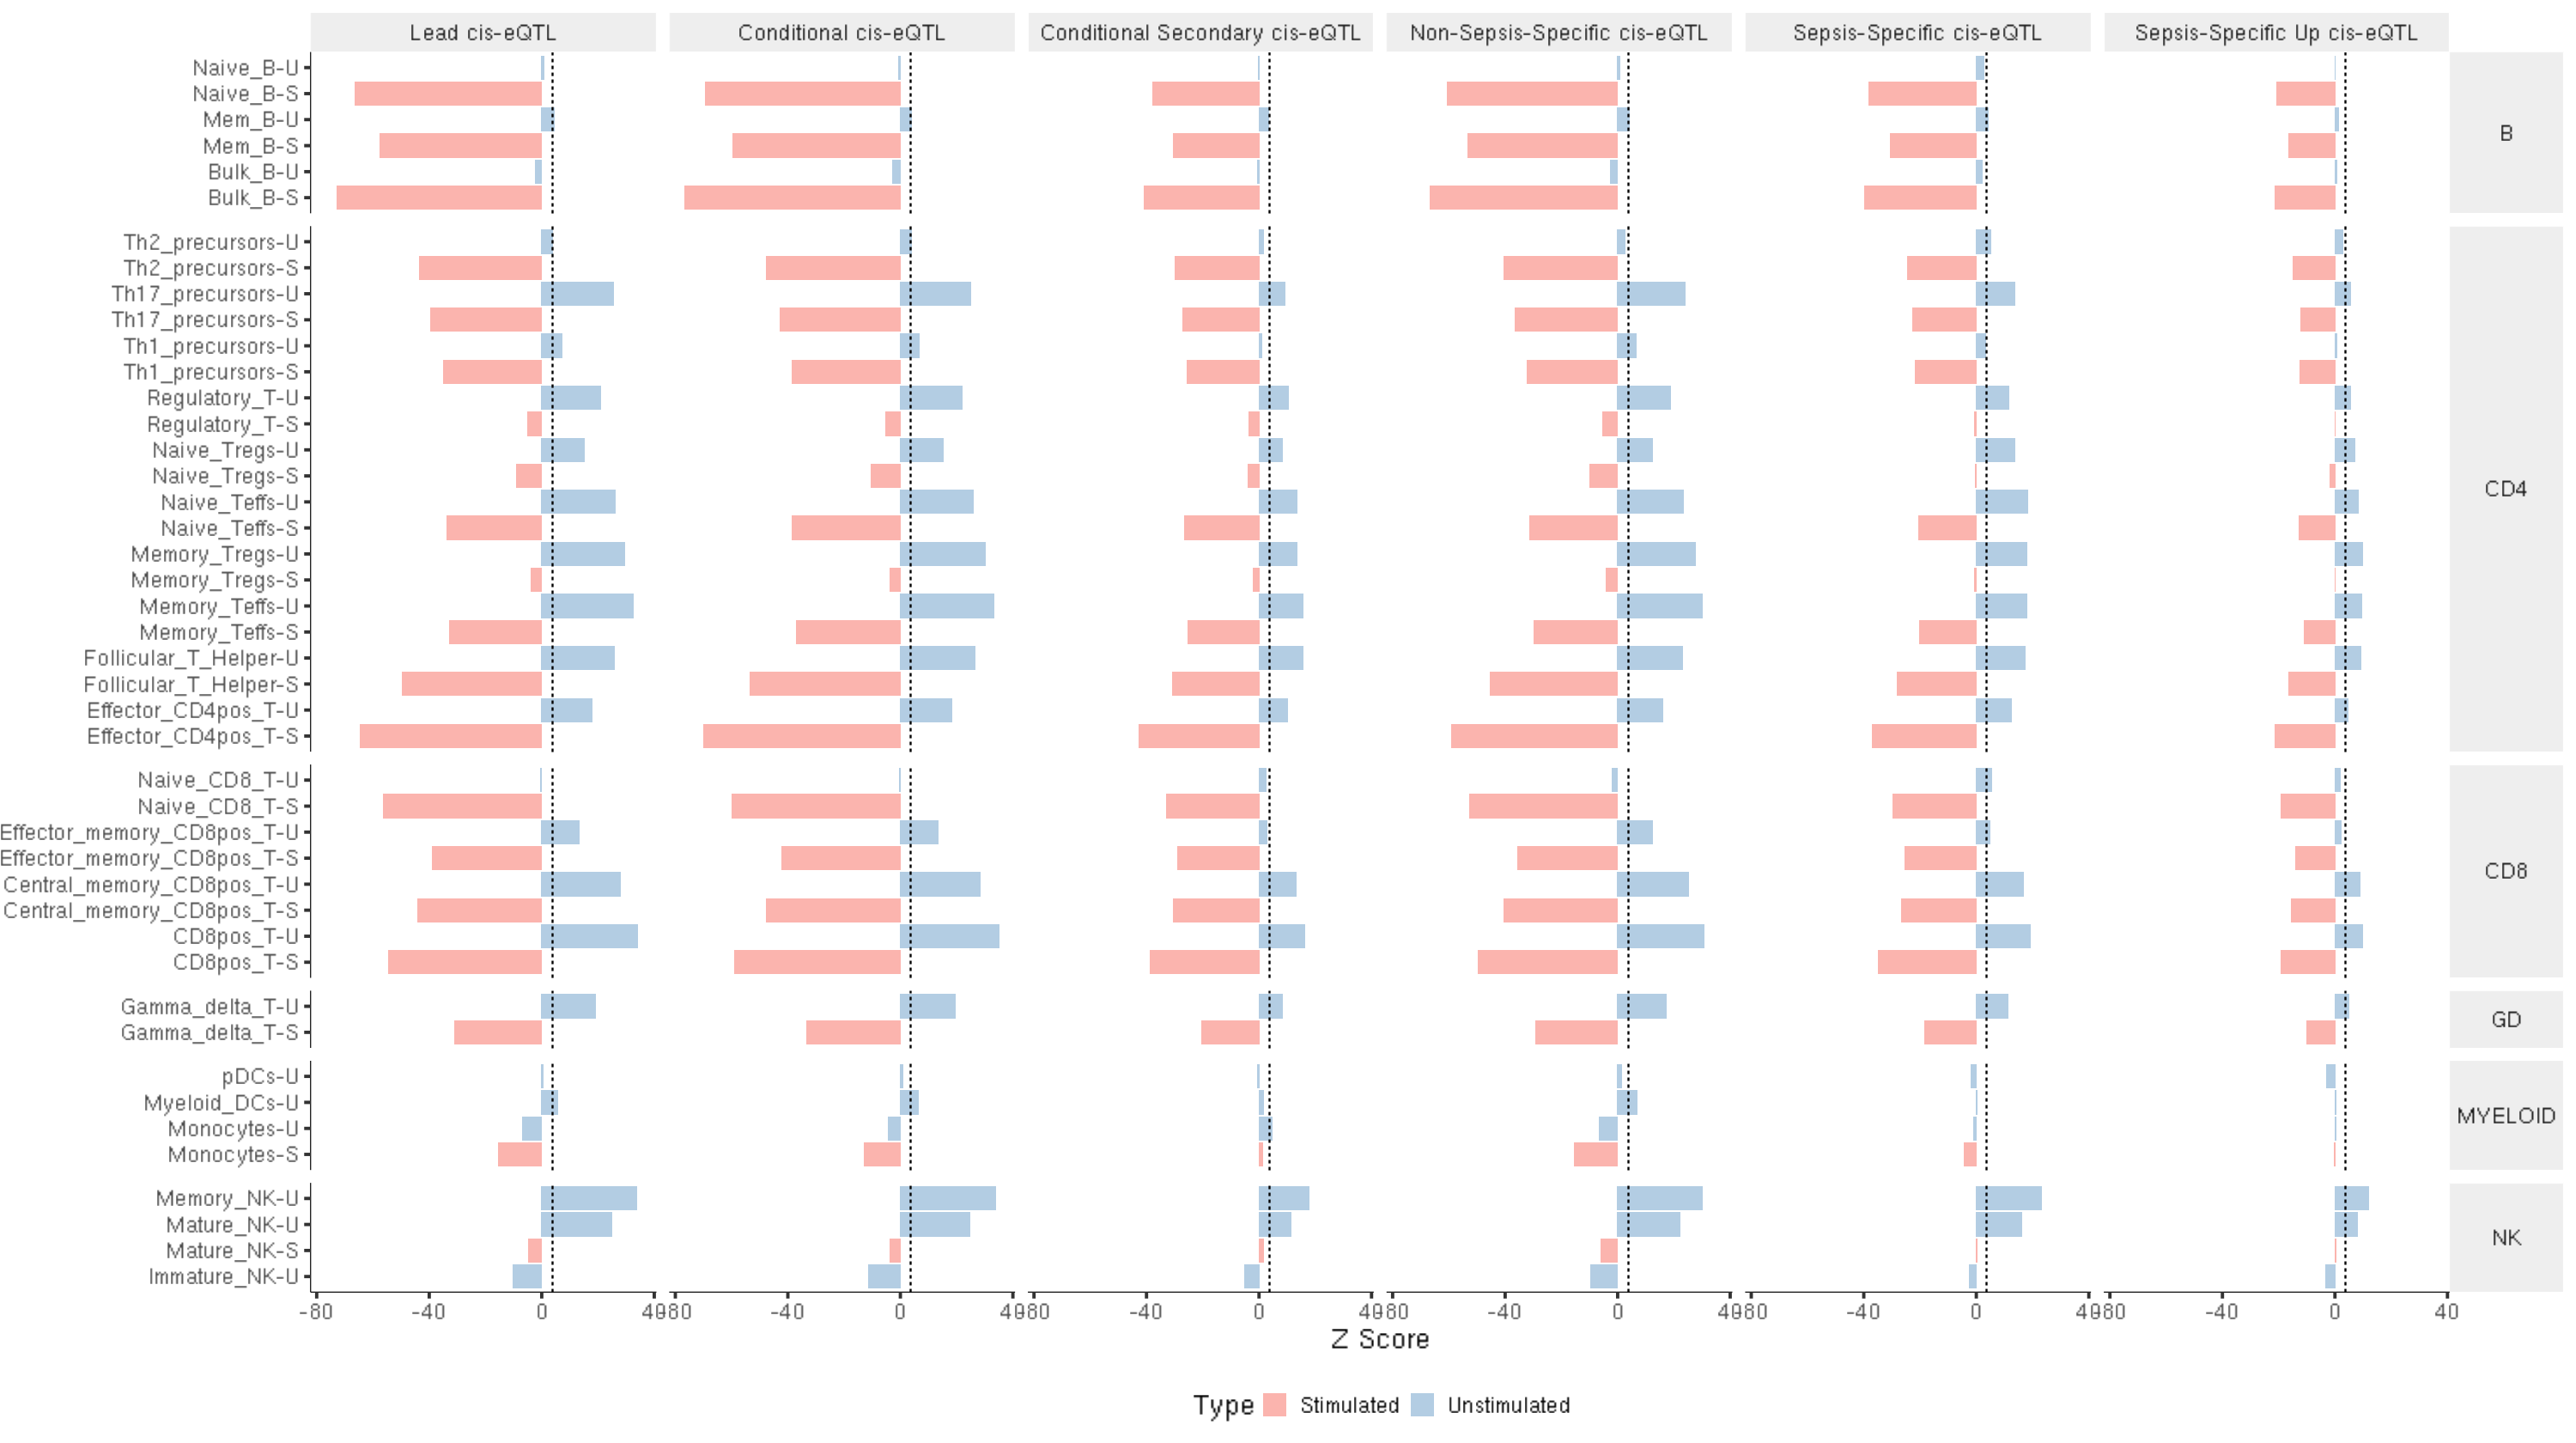

In [12]:
options(repr.plot.width=25, repr.plot.height=14)

merge(effects, p.vals, by=c("SNPs", "Condition")) %>%
    merge(., stat.info, by="SNPs") %>%
    dplyr::mutate(SNPs=factor(SNPs, levels=c("Lead cis-eQTL", "Conditional cis-eQTL", "Conditional Secondary cis-eQTL", "Non-Sepsis-Specific cis-eQTL", "Sepsis-Specific cis-eQTL", "Sepsis-Specific Up cis-eQTL"))) %>%
    dplyr::mutate(Z=(Rank.Mean - Mean) / SD) %>%
    dplyr::mutate(Cell_Type=gsub("-[SU]$", "", Condition)) %>%
    merge(., lineages, by="Cell_Type") %>%
    dplyr::mutate(Type=ifelse(grepl("-S$", Condition), "Stimulated", "Unstimulated")) %>%
    ggplot() + 
    geom_bar(aes(x=Condition, y=Z, fill=Type), stat="identity") +
    geom_hline(aes(yintercept=critical.value), lty=2) +
    facet_grid(Lineage ~ SNPs, scale="free_y", space="free_y") +
    scale_fill_brewer(palette="Pastel1") +
    coord_flip() +
    ylab("Z Score") +
    ggplot_theme +
    theme(axis.title.y=element_blank(), strip.text.y=element_text(angle=0))

ggsave("03_Functional_Interpretation/results/cheers_hg19_calderon_et_al_all.svg", width=25, height=14)

### Signal Association with ATAC-Seq Sample Quality

Since the pattern is repeated across various SNP lists, the sample quality of the ATAC-Seq samples may make it more likely for certain associations to come through because more peaks are being detected in those samples. Indeed, in my own processing of the data, I have noticed that sample quality is associated with specific cell types.

In [13]:
sample.qc <- readxl::read_xlsx("03_Functional_Interpretation/data/41588_2019_505_MOESM3_ESM.xlsx", sheet="ATAC-seq samle QC") %>%
    dplyr::mutate(condition=paste0(cell_type, "-", condition))

In [14]:
head(sample.qc)

sample,n_peaks,merged_final_read_count,tss_enrichment,donor,cell_type,condition
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1001-Bulk_B-S,99921,89133710,22.60328,1001,Bulk_B,Bulk_B-S
1001-Bulk_B-U,89186,75096300,21.60695,1001,Bulk_B,Bulk_B-U
1001-CD8pos_T-S,99319,79127056,19.86049,1001,CD8pos_T,CD8pos_T-S
1001-CD8pos_T-U,79809,83412526,21.93009,1001,CD8pos_T,CD8pos_T-U
1001-Central_memory_CD8pos_T-S,100868,56264624,18.59552,1001,Central_memory_CD8pos_T,Central_memory_CD8pos_T-S
1001-Central_memory_CD8pos_T-U,72386,54006014,22.54937,1001,Central_memory_CD8pos_T,Central_memory_CD8pos_T-U


`geom_smooth()` using formula 'y ~ x'



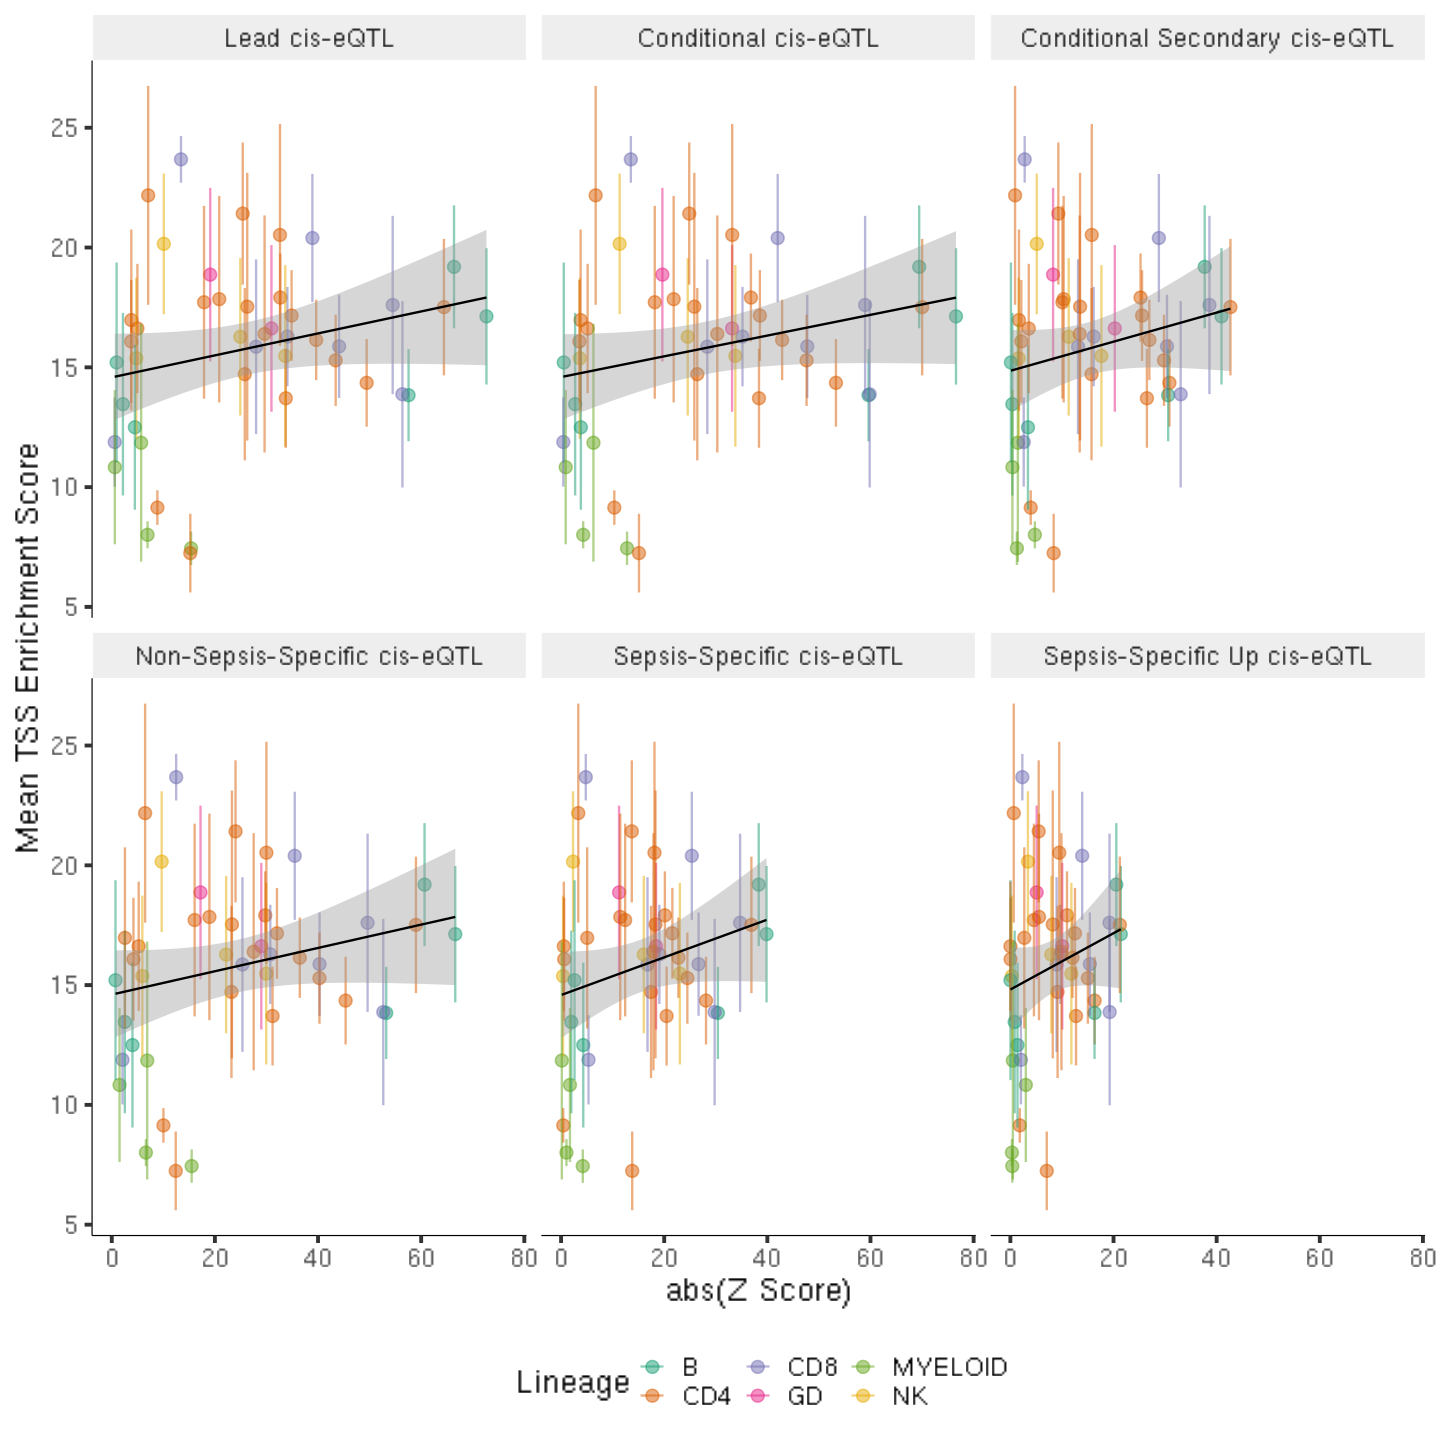

In [15]:
options(repr.plot.width=12, repr.plot.height=12)

merge(effects, p.vals, by=c("SNPs", "Condition")) %>%
    merge(., stat.info, by="SNPs") %>%
    dplyr::mutate(SNPs=factor(SNPs, levels=c("Lead cis-eQTL", "Conditional cis-eQTL", "Conditional Secondary cis-eQTL", "Non-Sepsis-Specific cis-eQTL", "Sepsis-Specific cis-eQTL", "Sepsis-Specific Up cis-eQTL"))) %>%
    dplyr::mutate(Z=abs((Rank.Mean - Mean) / SD)) %>%
    dplyr::mutate(Cell_Type=gsub("-[SU]$", "", Condition)) %>%
    merge(., lineages, by="Cell_Type") %>%
    merge(., sample.qc, by.x="Condition", by.y="condition") %>%
    dplyr::group_by(SNPs, Condition) %>%
    dplyr::summarize(Lineage=Lineage[1], Cell_Type=Cell_Type[1], Z=Z[1], Mean.TSS.Enrichment=mean(tss_enrichment), SE.TSS.Enrichment=sd(tss_enrichment) / sqrt(n()), .groups="drop") %>%
    dplyr::mutate(SE.Low=Mean.TSS.Enrichment - SE.TSS.Enrichment, SE.High=Mean.TSS.Enrichment + SE.TSS.Enrichment) %>%
    ggplot() +
    geom_point(aes(x=Z, y=Mean.TSS.Enrichment, color=Lineage), size=3, alpha=0.5) +
    geom_errorbar(aes(x=Z, ymin=SE.Low, ymax=SE.High, color=Lineage), alpha=0.5) +
    geom_smooth(aes(x=Z, y=Mean.TSS.Enrichment), method="lm", size=0.5, color="black") +
    facet_wrap(. ~ SNPs) +
    scale_color_brewer(palette="Dark2") +
    xlab("abs(Z Score)") + ylab("Mean TSS Enrichment Score") +
    ggplot_theme

## Stimulated Cell Conditions

### Load Data from Stimulated Cell Types

In [16]:
lead.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/lead_snps_stimulated_disease_enrichment_observedMeanRank.txt", 
    col.names=c("Condition", "Rank.Mean")
)
conditional.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_snps_stimulated_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)
conditional.secondary.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_secondary_snps_stimulated_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)
non.sepsis.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/non_sepsis_snps_stimulated_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)
sepsis.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_snps_stimulated_disease_enrichment_observedMeanRank.txt", 
    col.names=c("Condition", "Rank.Mean")
)
sepsis.up.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_up_snps_stimulated_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)

In [17]:
lead.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/lead_snps_stimulated_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
conditional.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_snps_stimulated_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
conditional.secondary.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_secondary_snps_stimulated_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
non.sepsis.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/non_sepsis_snps_stimulated_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
sepsis.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_snps_stimulated_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
sepsis.up.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_up_snps_stimulated_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))

In [18]:
lead.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/lead_snps_stimulated.log", sep="\t")
conditional.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_snps_stimulated.log", sep="\t")
conditional.secondary.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_secondary_snps_stimulated.log", sep="\t")
non.sepsis.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/non_sepsis_snps_stimulated.log", sep="\t")
sepsis.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_snps_stimulated.log", sep="\t")
sepsis.up.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_up_snps_stimulated.log", sep="\t")

In [19]:
stat.info <- data.frame(
    SNPs=c("Lead cis-eQTL", "Conditional cis-eQTL", "Conditional Secondary cis-eQTL", "Non-Sepsis-Specific cis-eQTL", "Sepsis-Specific cis-eQTL", "Sepsis-Specific Up cis-eQTL"),
    Mean=c(lead.summary[4,2], conditional.summary[4,2], conditional.secondary.summary[4,2], non.sepsis.summary[4,2], sepsis.summary[4,2], sepsis.up.summary[4,2]),
    SD=c(lead.summary[5,2], conditional.summary[5,2], conditional.secondary.summary[5,2], non.sepsis.summary[5,2], sepsis.summary[5,2], sepsis.up.summary[5,2])
)

head(stat.info)

,SNPs,Mean,SD
,<chr>,<dbl>,<dbl>
1,Lead cis-eQTL,361495.5,1076.0920
2,Conditional cis-eQTL,361495.5,966.7538
3,Conditional Secondary cis-eQTL,361495.5,1676.2306
4,Non-Sepsis-Specific cis-eQTL,361495.5,1171.9317
5,Sepsis-Specific cis-eQTL,361495.5,2078.0722
6,Sepsis-Specific Up cis-eQTL,361495.5,3364.5279


In [20]:
effects <- dplyr::bind_rows(
    lead.effects %>% dplyr::mutate(SNPs="Lead cis-eQTL"),
    conditional.effects %>% dplyr::mutate(SNPs="Conditional cis-eQTL"),
    conditional.secondary.effects %>% dplyr::mutate(SNPs="Conditional Secondary cis-eQTL"),
    non.sepsis.effects %>% dplyr::mutate(SNPs="Non-Sepsis-Specific cis-eQTL"),
    sepsis.effects %>% dplyr::mutate(SNPs="Sepsis-Specific cis-eQTL"),
    sepsis.up.effects %>% dplyr::mutate(SNPs="Sepsis-Specific Up cis-eQTL")
)

head(effects)

,Condition,Rank.Mean,SNPs
,<chr>,<dbl>,<chr>
1,Bulk_B-S,312542.7,Lead cis-eQTL
2,CD8pos_T-S,343209.5,Lead cis-eQTL
3,Central_memory_CD8pos_T-S,347336.9,Lead cis-eQTL
4,Effector_CD4pos_T-S,315638.6,Lead cis-eQTL
5,Effector_memory_CD8pos_T-S,353769.6,Lead cis-eQTL
6,Follicular_T_Helper-S,342091.3,Lead cis-eQTL


In [21]:
p.vals <- dplyr::bind_rows(
    lead.p.vals %>% dplyr::mutate(SNPs="Lead cis-eQTL"),
    conditional.p.vals %>% dplyr::mutate(SNPs="Conditional cis-eQTL"),
    conditional.secondary.p.vals %>% dplyr::mutate(SNPs="Conditional Secondary cis-eQTL"),
    non.sepsis.p.vals %>% dplyr::mutate(SNPs="Non-Sepsis-Specific cis-eQTL"),
    sepsis.p.vals %>% dplyr::mutate(SNPs="Sepsis-Specific cis-eQTL"),
    sepsis.up.p.vals %>% dplyr::mutate(SNPs="Sepsis-Specific Up cis-eQTL")
)

head(p.vals)

,Condition,P.Value,SNPs
,<chr>,<dbl>,<chr>
1,Bulk_B-S,1,Lead cis-eQTL
2,CD8pos_T-S,1,Lead cis-eQTL
3,Central_memory_CD8pos_T-S,1,Lead cis-eQTL
4,Effector_CD4pos_T-S,1,Lead cis-eQTL
5,Effector_memory_CD8pos_T-S,1,Lead cis-eQTL
6,Follicular_T_Helper-S,1,Lead cis-eQTL


### Enrichment of Different SNP Lists

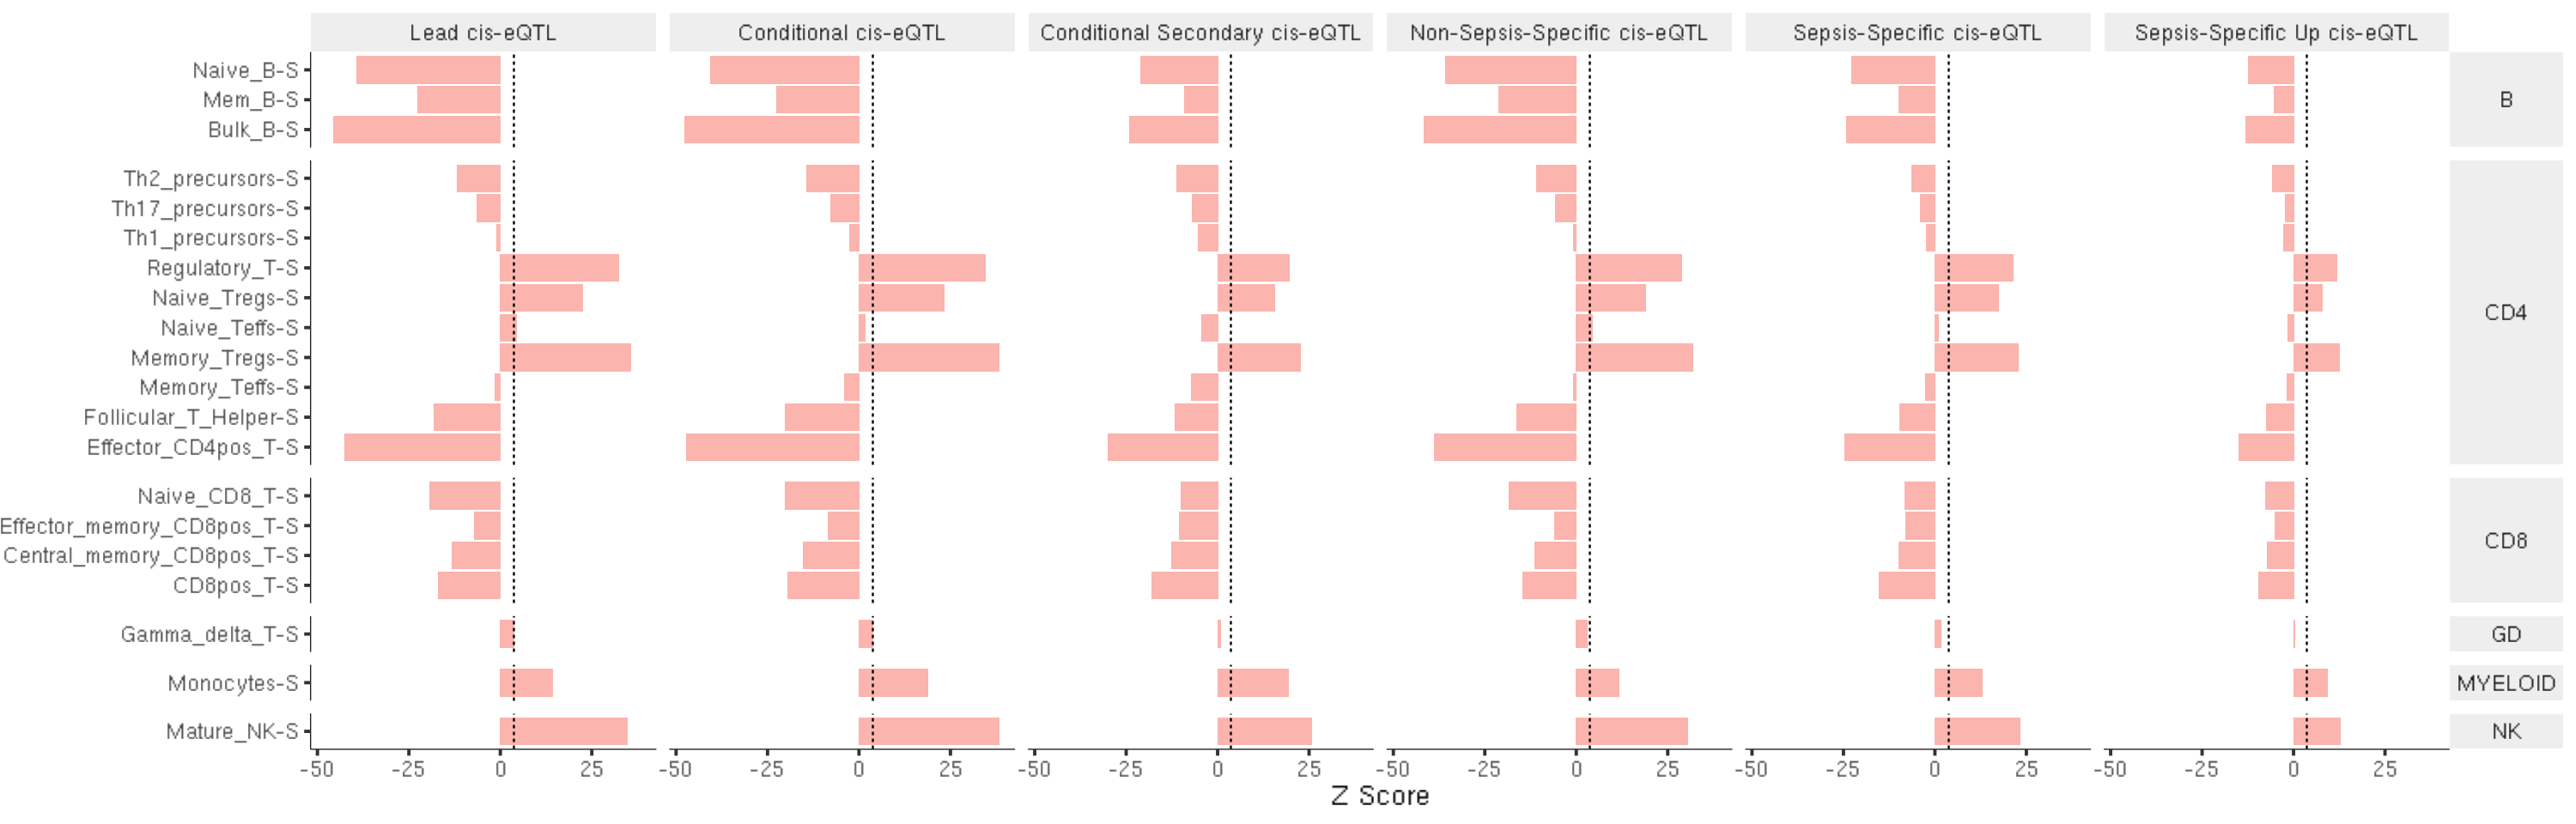

In [22]:
options(repr.plot.width=25, repr.plot.height=8)

merge(effects, p.vals, by=c("SNPs", "Condition")) %>%
    merge(., stat.info, by="SNPs") %>%
    dplyr::mutate(SNPs=factor(SNPs, levels=c("Lead cis-eQTL", "Conditional cis-eQTL", "Conditional Secondary cis-eQTL", "Non-Sepsis-Specific cis-eQTL", "Sepsis-Specific cis-eQTL", "Sepsis-Specific Up cis-eQTL"))) %>%
    dplyr::mutate(Z=(Rank.Mean - Mean) / SD) %>%
    dplyr::mutate(Cell_Type=gsub("-[SU]$", "", Condition)) %>%
    merge(., lineages, by="Cell_Type") %>%
    ggplot() + 
    geom_bar(aes(x=Condition, y=Z), stat="identity", fill=RColorBrewer::brewer.pal(n=3, name="Pastel1")[1]) +
    geom_hline(aes(yintercept=critical.value), lty=2) +
    facet_grid(Lineage ~ SNPs, scale="free_y", space="free_y") +
    coord_flip() +
    ylab("Z Score") +
    ggplot_theme +
    theme(axis.title.y=element_blank(), strip.text.y=element_text(angle=0))

ggsave("03_Functional_Interpretation/results/cheers_hg19_calderon_et_al_stimulated_all.svg", width=25, height=8)

### Enrichment of Secondary cis-eQTL

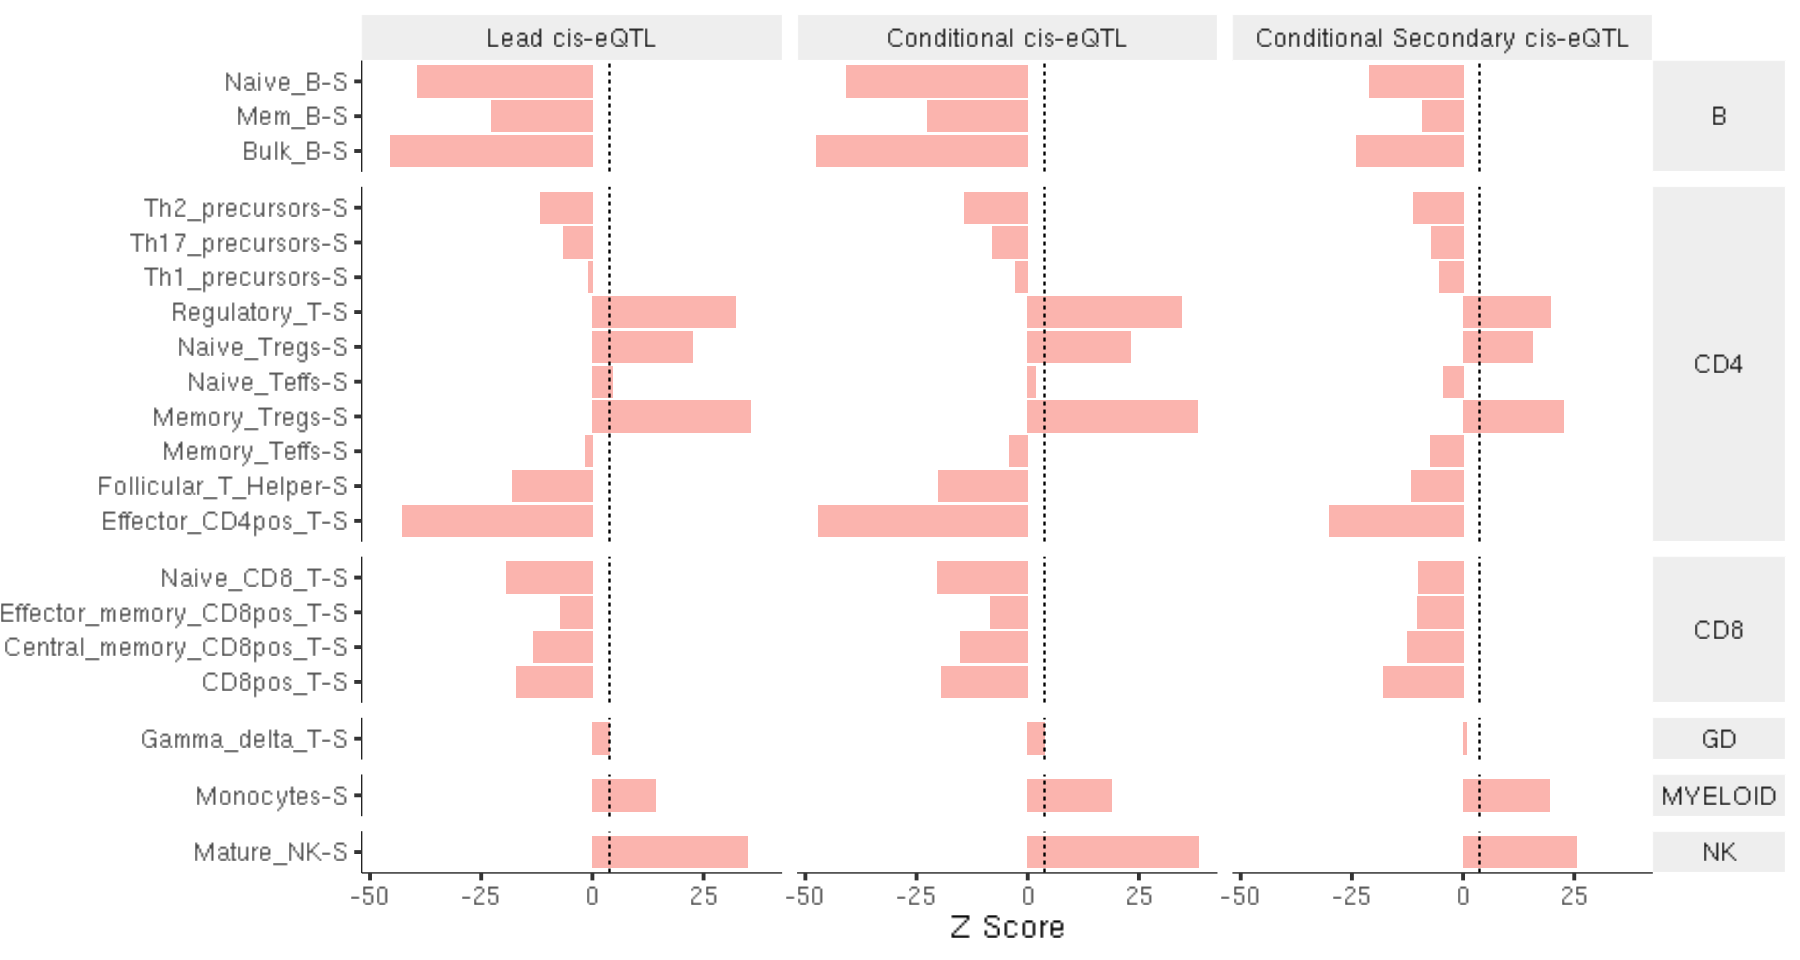

In [23]:
options(repr.plot.width=15, repr.plot.height=8)

merge(effects, p.vals, by=c("SNPs", "Condition")) %>%
    merge(., stat.info, by="SNPs") %>%
    dplyr::mutate(SNPs=factor(SNPs, levels=c("Lead cis-eQTL", "Conditional cis-eQTL", "Conditional Secondary cis-eQTL"))) %>%
    dplyr::filter(SNPs %in% c("Lead cis-eQTL", "Conditional cis-eQTL", "Conditional Secondary cis-eQTL")) %>%
    dplyr::mutate(Z=(Rank.Mean - Mean) / SD) %>%
    dplyr::mutate(Cell_Type=gsub("-[SU]$", "", Condition)) %>%
    merge(., lineages, by="Cell_Type") %>%
    ggplot() + 
    geom_bar(aes(x=Condition, y=Z), stat="identity", fill=RColorBrewer::brewer.pal(n=3, name="Pastel1")[1]) +
    geom_hline(aes(yintercept=critical.value), lty=2) +
    facet_grid(Lineage ~ SNPs, scale="free_y", space="free_y") +
    coord_flip() +
    ylab("Z Score") +
    ggplot_theme +
    theme(axis.title.y=element_blank(), strip.text.y=element_text(angle=0))

ggsave("03_Functional_Interpretation/results/cheers_hg19_calderon_et_al_stimulated_secondary_signals.svg", width=15, height=8)

### Enrichment of Sepsis-Specific cis-eQTL

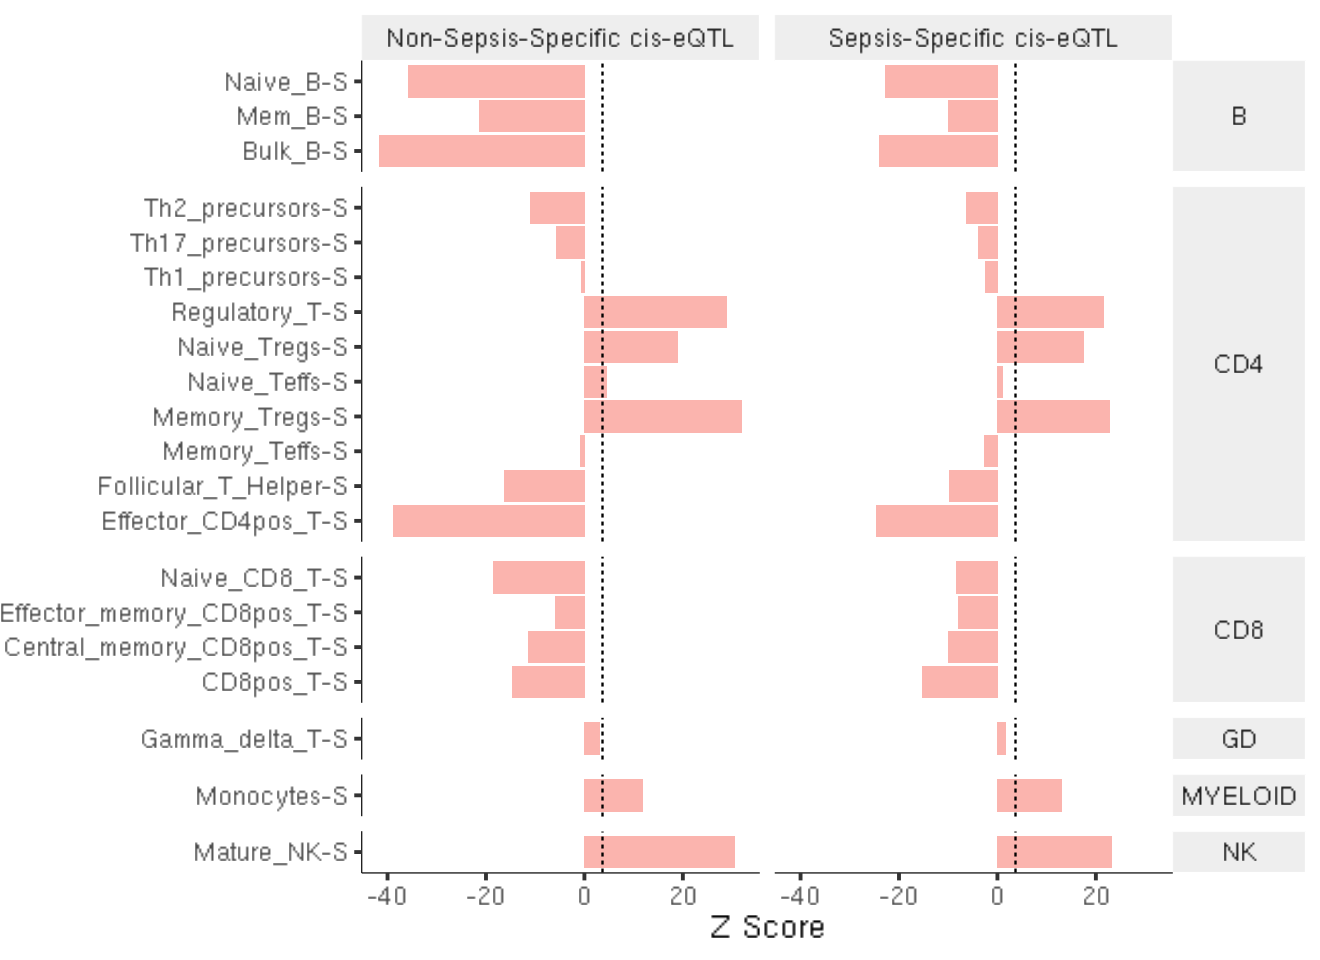

In [24]:
options(repr.plot.width=11, repr.plot.height=8)

merge(effects, p.vals, by=c("SNPs", "Condition")) %>%
    merge(., stat.info, by="SNPs") %>%
    dplyr::filter(SNPs %in% c("Sepsis-Specific cis-eQTL", "Non-Sepsis-Specific cis-eQTL")) %>%
    dplyr::mutate(Z=(Rank.Mean - Mean) / SD) %>%
    dplyr::mutate(Cell_Type=gsub("-[SU]$", "", Condition)) %>%
    merge(., lineages, by="Cell_Type") %>%
    ggplot() + 
    geom_bar(aes(x=Condition, y=Z), stat="identity", fill=RColorBrewer::brewer.pal(n=3, name="Pastel1")[1]) +
    geom_hline(aes(yintercept=critical.value), lty=2) +
    facet_grid(Lineage ~ SNPs, scale="free_y", space="free_y") +
    coord_flip() +
    ylab("Z Score") +
    ggplot_theme +
    theme(axis.title.y=element_blank(), strip.text.y=element_text(angle=0))

ggsave("03_Functional_Interpretation/results/cheers_hg19_calderon_et_al_stimulated_sepsis_specific.svg", width=11, height=8)

### Signal Association with ATAC-Seq Sample Quality

Since the pattern is repeated across various SNP lists, the sample quality of the ATAC-Seq samples may make it more likely for certain associations to come through because more peaks are being detected in those samples. Indeed, in my own processing of the data, I have noticed that sample quality is associated with specific cell types.

In [25]:
sample.qc <- readxl::read_xlsx("03_Functional_Interpretation/data/41588_2019_505_MOESM3_ESM.xlsx", sheet="ATAC-seq samle QC") %>%
    dplyr::mutate(condition=paste0(cell_type, "-", condition))

In [26]:
head(sample.qc)

sample,n_peaks,merged_final_read_count,tss_enrichment,donor,cell_type,condition
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1001-Bulk_B-S,99921,89133710,22.60328,1001,Bulk_B,Bulk_B-S
1001-Bulk_B-U,89186,75096300,21.60695,1001,Bulk_B,Bulk_B-U
1001-CD8pos_T-S,99319,79127056,19.86049,1001,CD8pos_T,CD8pos_T-S
1001-CD8pos_T-U,79809,83412526,21.93009,1001,CD8pos_T,CD8pos_T-U
1001-Central_memory_CD8pos_T-S,100868,56264624,18.59552,1001,Central_memory_CD8pos_T,Central_memory_CD8pos_T-S
1001-Central_memory_CD8pos_T-U,72386,54006014,22.54937,1001,Central_memory_CD8pos_T,Central_memory_CD8pos_T-U


`geom_smooth()` using formula 'y ~ x'



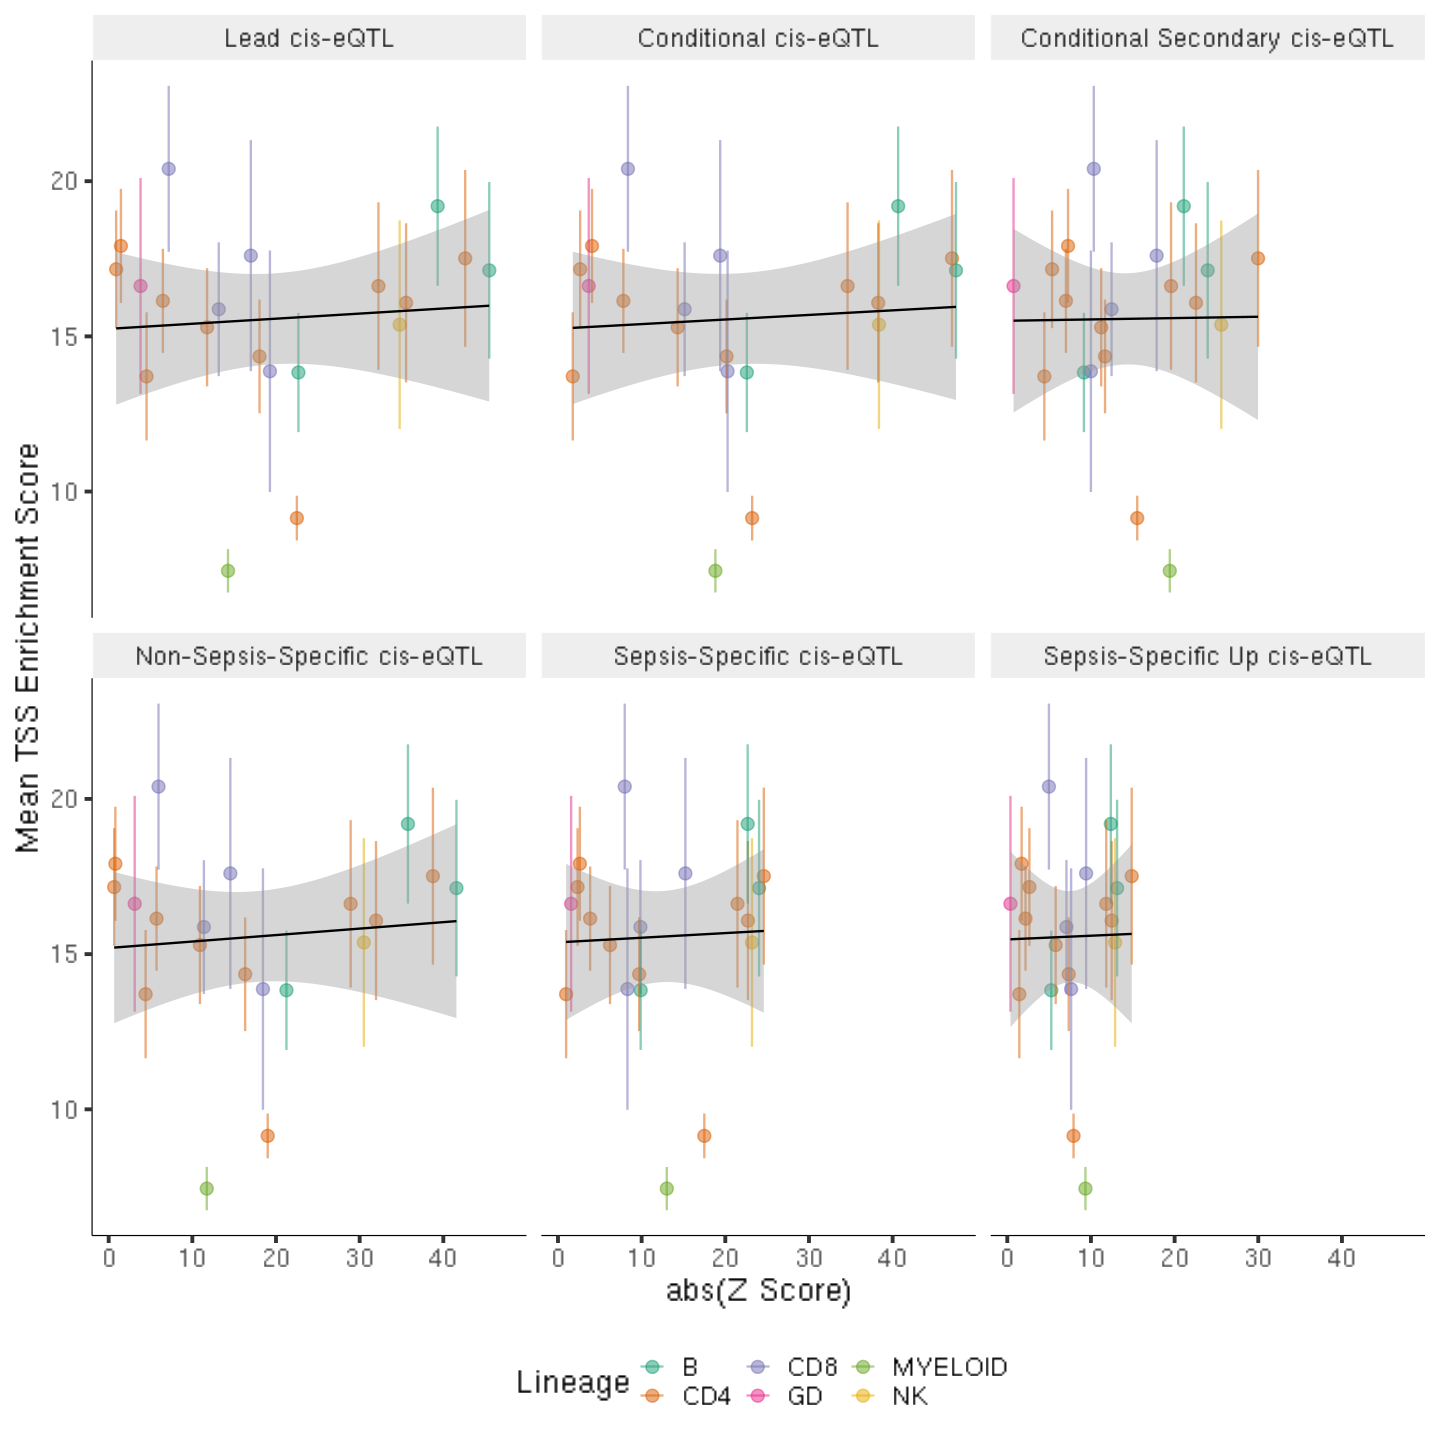

In [27]:
options(repr.plot.width=12, repr.plot.height=12)

merge(effects, p.vals, by=c("SNPs", "Condition")) %>%
    merge(., stat.info, by="SNPs") %>%
    dplyr::mutate(SNPs=factor(SNPs, levels=c("Lead cis-eQTL", "Conditional cis-eQTL", "Conditional Secondary cis-eQTL", "Non-Sepsis-Specific cis-eQTL", "Sepsis-Specific cis-eQTL", "Sepsis-Specific Up cis-eQTL"))) %>%
    dplyr::mutate(Z=abs((Rank.Mean - Mean) / SD)) %>%
    dplyr::mutate(Cell_Type=gsub("-[SU]$", "", Condition)) %>%
    merge(., lineages, by="Cell_Type") %>%
    merge(., sample.qc, by.x="Condition", by.y="condition") %>%
    dplyr::group_by(SNPs, Condition) %>%
    dplyr::summarize(Lineage=Lineage[1], Cell_Type=Cell_Type[1], Z=Z[1], Mean.TSS.Enrichment=mean(tss_enrichment), SE.TSS.Enrichment=sd(tss_enrichment) / sqrt(n()), .groups="drop") %>%
    dplyr::mutate(SE.Low=Mean.TSS.Enrichment - SE.TSS.Enrichment, SE.High=Mean.TSS.Enrichment + SE.TSS.Enrichment) %>%
    ggplot() +
    geom_point(aes(x=Z, y=Mean.TSS.Enrichment, color=Lineage), size=3, alpha=0.5) +
    geom_errorbar(aes(x=Z, ymin=SE.Low, ymax=SE.High, color=Lineage), alpha=0.5) +
    geom_smooth(aes(x=Z, y=Mean.TSS.Enrichment), method="lm", size=0.5, color="black") +
    facet_wrap(. ~ SNPs) +
    scale_color_brewer(palette="Dark2") +
    xlab("abs(Z Score)") + ylab("Mean TSS Enrichment Score") +
    ggplot_theme

## Unstimulated Cell Conditions

### Load Data from Unstimulated Cell Types

In [28]:
lead.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/lead_snps_unstimulated_disease_enrichment_observedMeanRank.txt", 
    col.names=c("Condition", "Rank.Mean")
)
conditional.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_snps_unstimulated_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)
conditional.secondary.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_secondary_snps_unstimulated_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)
non.sepsis.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/non_sepsis_snps_unstimulated_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)
sepsis.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_snps_unstimulated_disease_enrichment_observedMeanRank.txt", 
    col.names=c("Condition", "Rank.Mean")
)
sepsis.up.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_up_snps_unstimulated_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)

In [29]:
lead.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/lead_snps_unstimulated_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
conditional.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_snps_unstimulated_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
conditional.secondary.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_secondary_snps_unstimulated_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
non.sepsis.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/non_sepsis_snps_unstimulated_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
sepsis.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_snps_unstimulated_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
sepsis.up.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_up_snps_unstimulated_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))

In [30]:
lead.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/lead_snps_unstimulated.log", sep="\t")
conditional.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_snps_unstimulated.log", sep="\t")
conditional.secondary.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_secondary_snps_unstimulated.log", sep="\t")
non.sepsis.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/non_sepsis_snps_unstimulated.log", sep="\t")
sepsis.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_snps_unstimulated.log", sep="\t")
sepsis.up.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_up_snps_unstimulated.log", sep="\t")

In [31]:
stat.info <- data.frame(
    SNPs=c("Lead cis-eQTL", "Conditional cis-eQTL", "Conditional Secondary cis-eQTL", "Non-Sepsis-Specific cis-eQTL", "Sepsis-Specific cis-eQTL", "Sepsis-Specific Up cis-eQTL"),
    Mean=c(lead.summary[4,2], conditional.summary[4,2], conditional.secondary.summary[4,2], non.sepsis.summary[4,2], sepsis.summary[4,2], sepsis.up.summary[4,2]),
    SD=c(lead.summary[5,2], conditional.summary[5,2], conditional.secondary.summary[5,2], non.sepsis.summary[5,2], sepsis.summary[5,2], sepsis.up.summary[5,2])
)

head(stat.info)

,SNPs,Mean,SD
,<chr>,<dbl>,<dbl>
1,Lead cis-eQTL,361495.5,1068.9972
2,Conditional cis-eQTL,361495.5,960.6415
3,Conditional Secondary cis-eQTL,361495.5,1666.4240
4,Non-Sepsis-Specific cis-eQTL,361495.5,1164.5566
5,Sepsis-Specific cis-eQTL,361495.5,2064.1022
6,Sepsis-Specific Up cis-eQTL,361495.5,3345.4554


In [32]:
effects <- dplyr::bind_rows(
    lead.effects %>% dplyr::mutate(SNPs="Lead cis-eQTL"),
    conditional.effects %>% dplyr::mutate(SNPs="Conditional cis-eQTL"),
    conditional.secondary.effects %>% dplyr::mutate(SNPs="Conditional Secondary cis-eQTL"),
    non.sepsis.effects %>% dplyr::mutate(SNPs="Non-Sepsis-Specific cis-eQTL"),
    sepsis.effects %>% dplyr::mutate(SNPs="Sepsis-Specific cis-eQTL"),
    sepsis.up.effects %>% dplyr::mutate(SNPs="Sepsis-Specific Up cis-eQTL")
)

head(effects)

,Condition,Rank.Mean,SNPs
,<chr>,<dbl>,<chr>
1,Bulk_B-U,335891.2,Lead cis-eQTL
2,CD8pos_T-U,368274.2,Lead cis-eQTL
3,Central_memory_CD8pos_T-U,370066.2,Lead cis-eQTL
4,Effector_CD4pos_T-U,358151.1,Lead cis-eQTL
5,Effector_memory_CD8pos_T-U,357582.1,Lead cis-eQTL
6,Follicular_T_Helper-U,365926.4,Lead cis-eQTL


In [33]:
p.vals <- dplyr::bind_rows(
    lead.p.vals %>% dplyr::mutate(SNPs="Lead cis-eQTL"),
    conditional.p.vals %>% dplyr::mutate(SNPs="Conditional cis-eQTL"),
    conditional.secondary.p.vals %>% dplyr::mutate(SNPs="Conditional Secondary cis-eQTL"),
    non.sepsis.p.vals %>% dplyr::mutate(SNPs="Non-Sepsis-Specific cis-eQTL"),
    sepsis.p.vals %>% dplyr::mutate(SNPs="Sepsis-Specific cis-eQTL"),
    sepsis.up.p.vals %>% dplyr::mutate(SNPs="Sepsis-Specific Up cis-eQTL")
)

head(p.vals)

,Condition,P.Value,SNPs
,<chr>,<dbl>,<chr>
1,Bulk_B-U,1.000000e+00,Lead cis-eQTL
2,CD8pos_T-U,1.139761e-10,Lead cis-eQTL
3,Central_memory_CD8pos_T-U,5.551115e-16,Lead cis-eQTL
4,Effector_CD4pos_T-U,9.991216e-01,Lead cis-eQTL
5,Effector_memory_CD8pos_T-U,9.998743e-01,Lead cis-eQTL
6,Follicular_T_Helper-U,1.699588e-05,Lead cis-eQTL


### Enrichment of Different SNP Lists

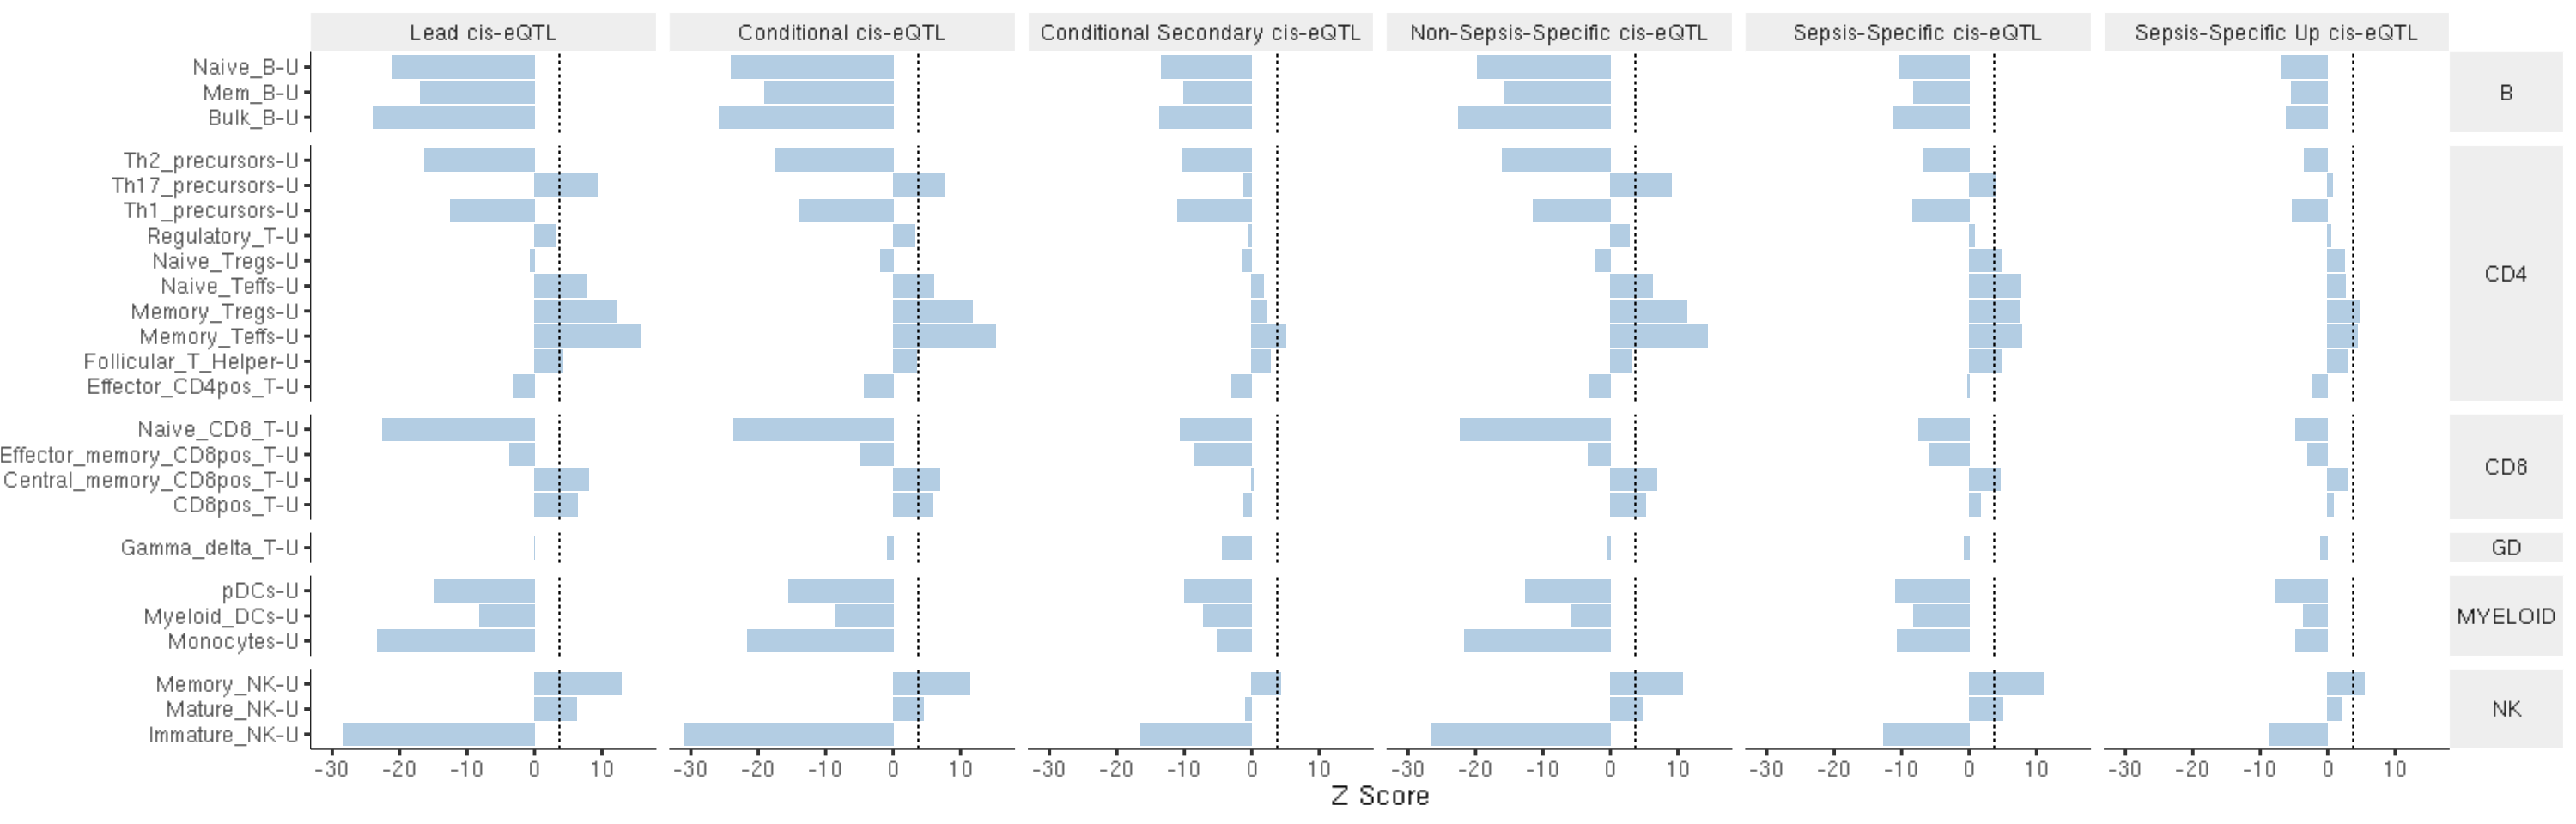

In [34]:
options(repr.plot.width=25, repr.plot.height=8)

merge(effects, p.vals, by=c("SNPs", "Condition")) %>%
    merge(., stat.info, by="SNPs") %>%
    dplyr::mutate(SNPs=factor(SNPs, levels=c("Lead cis-eQTL", "Conditional cis-eQTL", "Conditional Secondary cis-eQTL", "Non-Sepsis-Specific cis-eQTL", "Sepsis-Specific cis-eQTL", "Sepsis-Specific Up cis-eQTL"))) %>%
    dplyr::mutate(Z=(Rank.Mean - Mean) / SD) %>%
    dplyr::mutate(Cell_Type=gsub("-[SU]$", "", Condition)) %>%
    merge(., lineages, by="Cell_Type") %>%
    ggplot() + 
    geom_bar(aes(x=Condition, y=Z), stat="identity", fill=RColorBrewer::brewer.pal(n=3, name="Pastel1")[2]) +
    geom_hline(aes(yintercept=critical.value), lty=2) +
    facet_grid(Lineage ~ SNPs, scale="free_y", space="free_y") +
    coord_flip() +
    ylab("Z Score") +
    ggplot_theme +
    theme(axis.title.y=element_blank(), strip.text.y=element_text(angle=0))

ggsave("03_Functional_Interpretation/results/cheers_hg19_calderon_et_al_unstimulated_all.svg", width=25, height=8)

### Enrichment of Secondary cis-eQTL

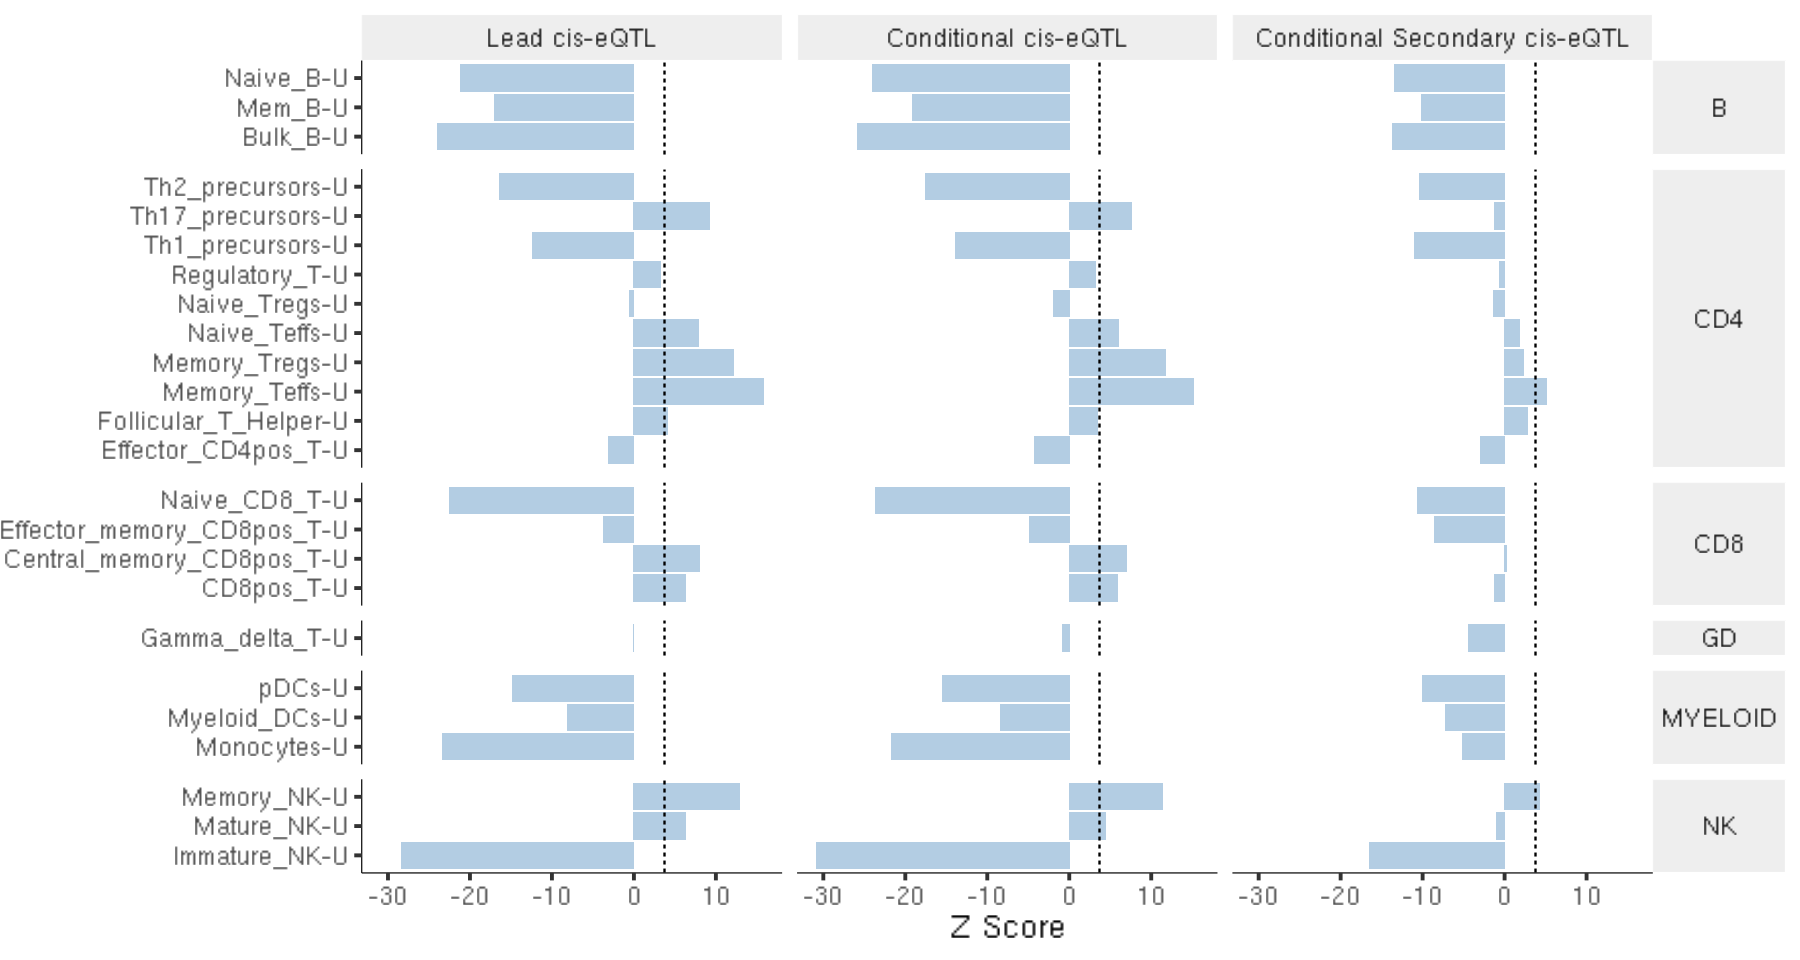

In [35]:
options(repr.plot.width=15, repr.plot.height=8)

merge(effects, p.vals, by=c("SNPs", "Condition")) %>%
    merge(., stat.info, by="SNPs") %>%
    dplyr::mutate(SNPs=factor(SNPs, levels=c("Lead cis-eQTL", "Conditional cis-eQTL", "Conditional Secondary cis-eQTL"))) %>%
    dplyr::filter(SNPs %in% c("Lead cis-eQTL", "Conditional cis-eQTL", "Conditional Secondary cis-eQTL")) %>%
    dplyr::mutate(Z=(Rank.Mean - Mean) / SD) %>%
    dplyr::mutate(Cell_Type=gsub("-[SU]$", "", Condition)) %>%
    merge(., lineages, by="Cell_Type") %>%
    ggplot() + 
    geom_bar(aes(x=Condition, y=Z), stat="identity", fill=RColorBrewer::brewer.pal(n=3, name="Pastel1")[2]) +
    geom_hline(aes(yintercept=critical.value), lty=2) +
    facet_grid(Lineage ~ SNPs, scale="free_y", space="free_y") +
    coord_flip() +
    ylab("Z Score") +
    ggplot_theme +
    theme(axis.title.y=element_blank(), strip.text.y=element_text(angle=0))

ggsave("03_Functional_Interpretation/results/cheers_hg19_calderon_et_al_unstimulated_secondary_signals.svg", width=15, height=8)

### Enrichment of Sepsis-Specific cis-eQTL

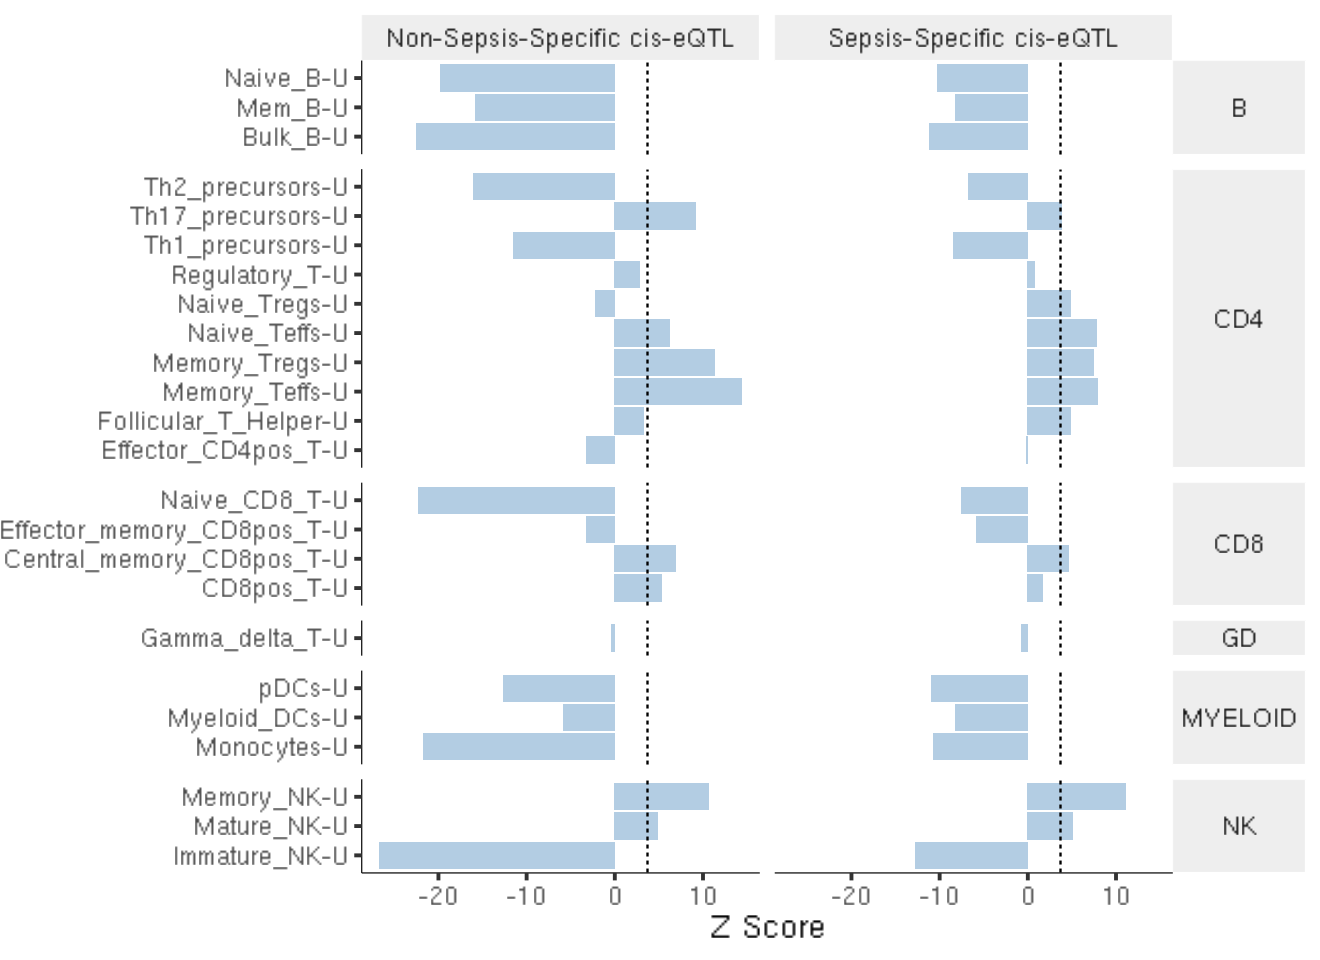

In [36]:
options(repr.plot.width=11, repr.plot.height=8)

merge(effects, p.vals, by=c("SNPs", "Condition")) %>%
    merge(., stat.info, by="SNPs") %>%
    dplyr::filter(SNPs %in% c("Sepsis-Specific cis-eQTL", "Non-Sepsis-Specific cis-eQTL")) %>%
    dplyr::mutate(Z=(Rank.Mean - Mean) / SD) %>%
    dplyr::mutate(Cell_Type=gsub("-[SU]$", "", Condition)) %>%
    merge(., lineages, by="Cell_Type") %>%
    ggplot() + 
    geom_bar(aes(x=Condition, y=Z), stat="identity", fill=RColorBrewer::brewer.pal(n=3, name="Pastel1")[2]) +
    geom_hline(aes(yintercept=critical.value), lty=2) +
    facet_grid(Lineage ~ SNPs, scale="free_y", space="free_y") +
    coord_flip() +
    ylab("Z Score") +
    ggplot_theme +
    theme(axis.title.y=element_blank(), strip.text.y=element_text(angle=0))

ggsave("03_Functional_Interpretation/results/cheers_hg19_calderon_et_al_unstimulated_sepsis_specific.svg", width=11, height=8)

### Signal Association with ATAC-Seq Sample Quality

Since the pattern is repeated across various SNP lists, the sample quality of the ATAC-Seq samples may make it more likely for certain associations to come through because more peaks are being detected in those samples. Indeed, in my own processing of the data, I have noticed that sample quality is associated with specific cell types.

In [37]:
sample.qc <- readxl::read_xlsx("03_Functional_Interpretation/data/41588_2019_505_MOESM3_ESM.xlsx", sheet="ATAC-seq samle QC") %>%
    dplyr::mutate(condition=paste0(cell_type, "-", condition))

In [38]:
head(sample.qc)

sample,n_peaks,merged_final_read_count,tss_enrichment,donor,cell_type,condition
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1001-Bulk_B-S,99921,89133710,22.60328,1001,Bulk_B,Bulk_B-S
1001-Bulk_B-U,89186,75096300,21.60695,1001,Bulk_B,Bulk_B-U
1001-CD8pos_T-S,99319,79127056,19.86049,1001,CD8pos_T,CD8pos_T-S
1001-CD8pos_T-U,79809,83412526,21.93009,1001,CD8pos_T,CD8pos_T-U
1001-Central_memory_CD8pos_T-S,100868,56264624,18.59552,1001,Central_memory_CD8pos_T,Central_memory_CD8pos_T-S
1001-Central_memory_CD8pos_T-U,72386,54006014,22.54937,1001,Central_memory_CD8pos_T,Central_memory_CD8pos_T-U


`geom_smooth()` using formula 'y ~ x'



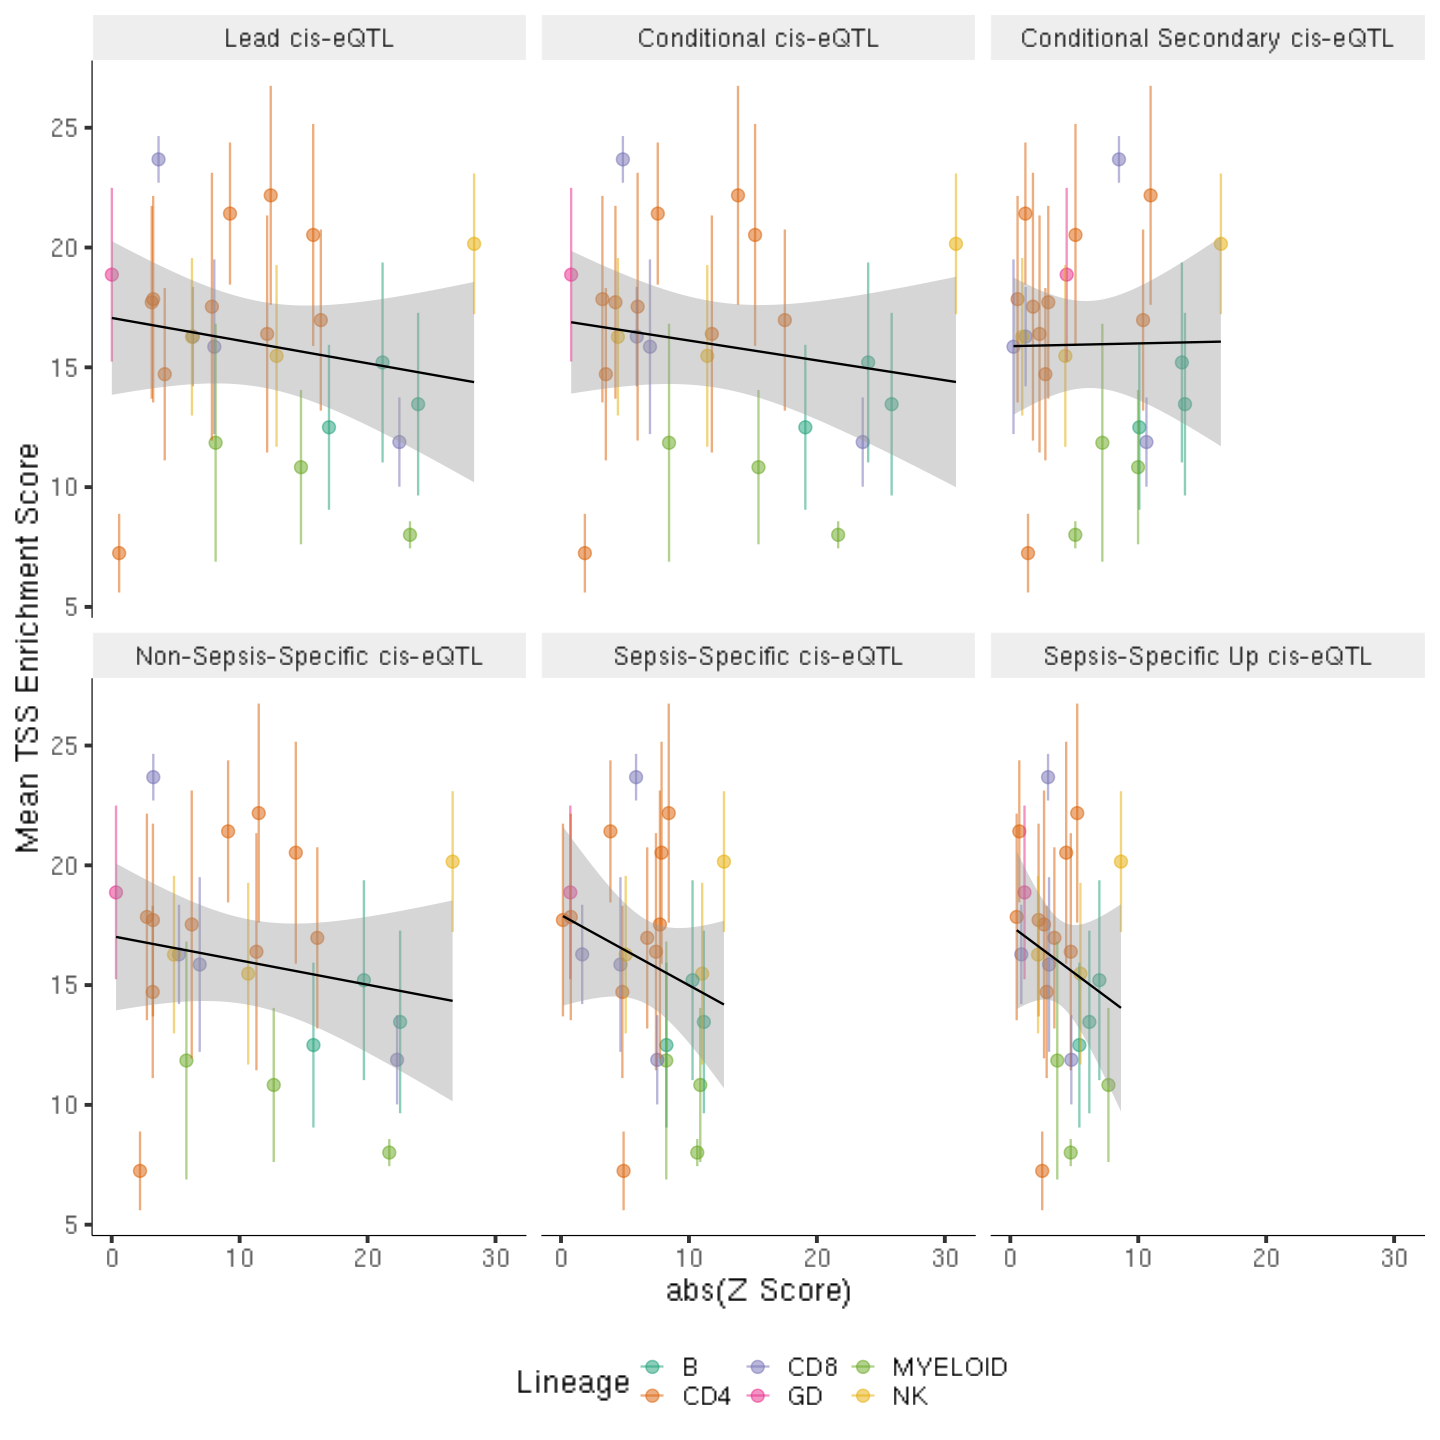

In [39]:
options(repr.plot.width=12, repr.plot.height=12)

merge(effects, p.vals, by=c("SNPs", "Condition")) %>%
    merge(., stat.info, by="SNPs") %>%
    dplyr::mutate(SNPs=factor(SNPs, levels=c("Lead cis-eQTL", "Conditional cis-eQTL", "Conditional Secondary cis-eQTL", "Non-Sepsis-Specific cis-eQTL", "Sepsis-Specific cis-eQTL", "Sepsis-Specific Up cis-eQTL"))) %>%
    dplyr::mutate(Z=abs((Rank.Mean - Mean) / SD)) %>%
    dplyr::mutate(Cell_Type=gsub("-[SU]$", "", Condition)) %>%
    merge(., lineages, by="Cell_Type") %>%
    merge(., sample.qc, by.x="Condition", by.y="condition") %>%
    dplyr::group_by(SNPs, Condition) %>%
    dplyr::summarize(Lineage=Lineage[1], Cell_Type=Cell_Type[1], Z=Z[1], Mean.TSS.Enrichment=mean(tss_enrichment), SE.TSS.Enrichment=sd(tss_enrichment) / sqrt(n()), .groups="drop") %>%
    dplyr::mutate(SE.Low=Mean.TSS.Enrichment - SE.TSS.Enrichment, SE.High=Mean.TSS.Enrichment + SE.TSS.Enrichment) %>%
    ggplot() +
    geom_point(aes(x=Z, y=Mean.TSS.Enrichment, color=Lineage), size=3, alpha=0.5) +
    geom_errorbar(aes(x=Z, ymin=SE.Low, ymax=SE.High, color=Lineage), alpha=0.5) +
    geom_smooth(aes(x=Z, y=Mean.TSS.Enrichment), method="lm", size=0.5, color="black") +
    facet_wrap(. ~ SNPs) +
    scale_color_brewer(palette="Dark2") +
    xlab("abs(Z Score)") + ylab("Mean TSS Enrichment Score") +
    ggplot_theme

## Peaks Driving Cell-Type-Specific Enrichment

CHEERS works on cell-type-specificity scores for peaks. We can use these specificity scores to understand which peaks are driving the enrichment signal.

In [243]:
stimulated.norm <- fread("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/normalized/Calderon_et_al_stimulated_counts_normToMax_quantileNorm_euclideanNorm.txt") %>%
    as.data.frame() %>%
    dplyr::mutate(ID=paste0(chr, ":", start, "-", end))

rownames(stimulated.norm) <- stimulated.norm$ID

stimulated.norm <- stimulated.norm %>%
    dplyr::select(everything(), -chr, -start, -end, -ID) %>%
    apply(., 2, function(x) { rank(x, ties.method="min") })

In [244]:
non.sepsis.overlaps <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/non_sepsis_snps_stimulated_SNPsOverlappingPeaks.txt", sep="\t", header=TRUE)

sepsis.overlaps <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_snps_stimulated_SNPsOverlappingPeaks.txt", sep="\t", header=TRUE)

In [245]:
peak.ids <- with(sepsis.overlaps, paste0(chr, ":", start, "-", end))
rank.data <- stimulated.norm[peak.ids,] / mean(stimulated.norm)
percentile.90th <- quantile(apply(rank.data, 1, max), probs=c(0.9))
sepsis.peak.ids <- rownames(rank.data)[apply(rank.data, 1, max) > percentile.90th]

In [246]:
peak.ids <- with(non.sepsis.overlaps, paste0(chr, ":", start, "-", end))
rank.data <- stimulated.norm[peak.ids,] / mean(stimulated.norm)
percentile.90th <- quantile(apply(rank.data, 1, max), probs=c(0.9))
non.sepsis.peak.ids <- rownames(rank.data)[apply(rank.data, 1, max) > percentile.90th]

In [247]:
peak.ids <- sort(union(sepsis.peak.ids, non.sepsis.peak.ids))
plot.data <- stimulated.norm[peak.ids,] / mean(stimulated.norm)

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



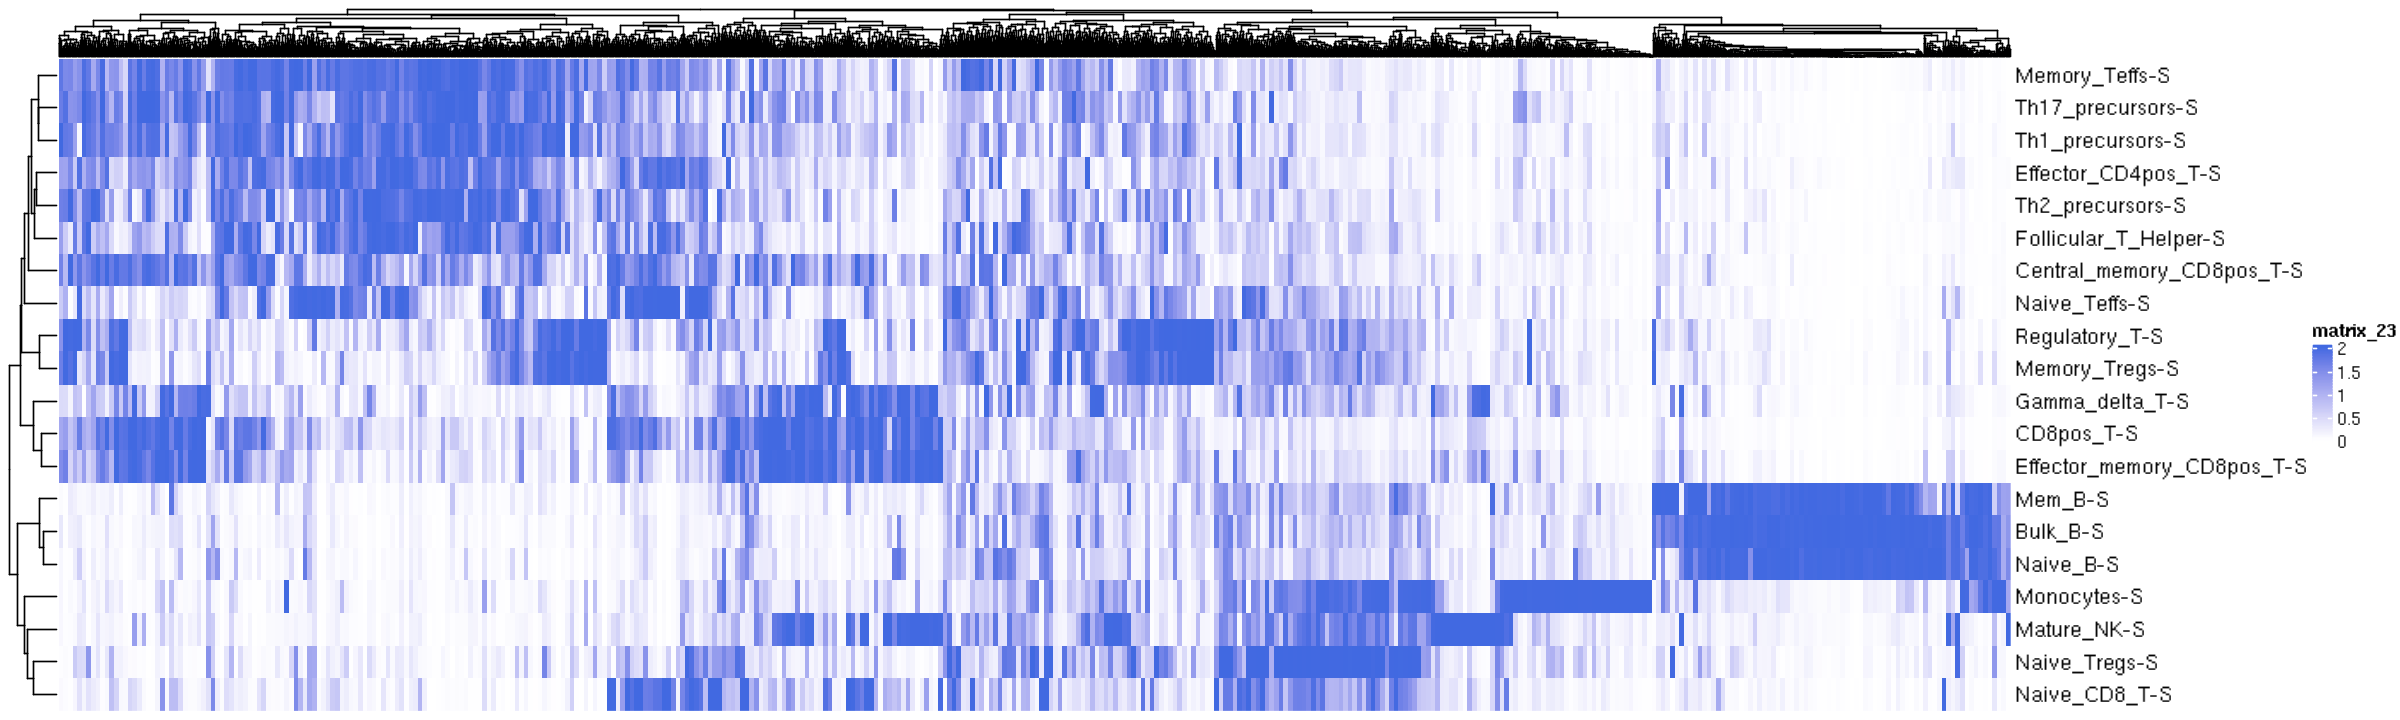

In [256]:
options(repr.plot.width=20, repr.plot.height=6)

col_fun = circlize::colorRamp2(c(0, 2), c("white", "royalblue"))
Heatmap(t(plot.data), col=col_fun, show_column_names=F, use_raster=TRUE)

In [207]:
head(stimulated.norm)

,Bulk_B-S,CD8pos_T-S,Central_memory_CD8pos_T-S,Effector_CD4pos_T-S,Effector_memory_CD8pos_T-S,Follicular_T_Helper-S,Gamma_delta_T-S,Mature_NK-S,Mem_B-S,Memory_Teffs-S,Memory_Tregs-S,Monocytes-S,Naive_B-S,Naive_CD8_T-S,Naive_Teffs-S,Naive_Tregs-S,Regulatory_T-S,Th17_precursors-S,Th1_precursors-S,Th2_precursors-S
chr1:10045-10517,647952,150700,123723,246488,327752,167444,189549,323466,416176,187966,711727,94987,597349,404092,179119,58165,717104,289795,356246,232813
chr1:237698-237812,443277,316508,249261,694108,493718,604230,185910,27957,409107,666044,105515,461751,557531,261090,348968,12957,404814,504879,551672,455015
chr1:540672-541256,123407,715430,720352,490482,662860,397807,704096,99399,13655,454341,61125,116846,147751,261090,558423,65746,299827,499350,449804,69390
chr1:564524-564725,42,12919,167275,3,44295,184918,710657,57690,1,384595,346200,686338,1,715029,189207,722859,336919,40678,83802,440986
chr1:567099-567618,122434,578127,714301,104443,24073,704551,522407,57138,143678,150794,91765,66956,250311,716296,713910,4,708949,23844,14233,463542
chr1:569577-570156,75089,270550,535561,309917,110373,537162,301713,323466,634788,339712,219629,320772,87407,649353,701966,608465,567219,99787,159480,642353


In [282]:
sepsis.overlaps.peaks <- with(sepsis.overlaps, paste0(chr, ":", start, "-", end))
non.sepsis.overlaps.peaks <- with(non.sepsis.overlaps, paste0(chr, ":", start, "-", end))
both.peaks <- intersect(sepsis.overlaps.peaks, non.sepsis.overlaps.peaks)
sepsis.overlaps.peaks <- setdiff(sepsis.overlaps.peaks, both.peaks)
non.sepsis.overlaps.peaks <- setdiff(non.sepsis.overlaps.peaks, both.peaks)

plot.data <- do.call(rbind, lapply(colnames(stimulated.norm), function(condition) {

    percentile.90th <- quantile(stimulated.norm[,condition], probs=0.999)
    top.peak.ids <- rownames(stimulated.norm)[stimulated.norm[,condition] > percentile.90th]

    c(
        sum(top.peak.ids %in% sepsis.overlaps.peaks),
        sum(top.peak.ids %in% non.sepsis.overlaps.peaks),
        sum(top.peak.ids %in% both.peaks)
    )
}))
colnames(plot.data) <- c("Sepsis", "Non_Sepsis", "Both")

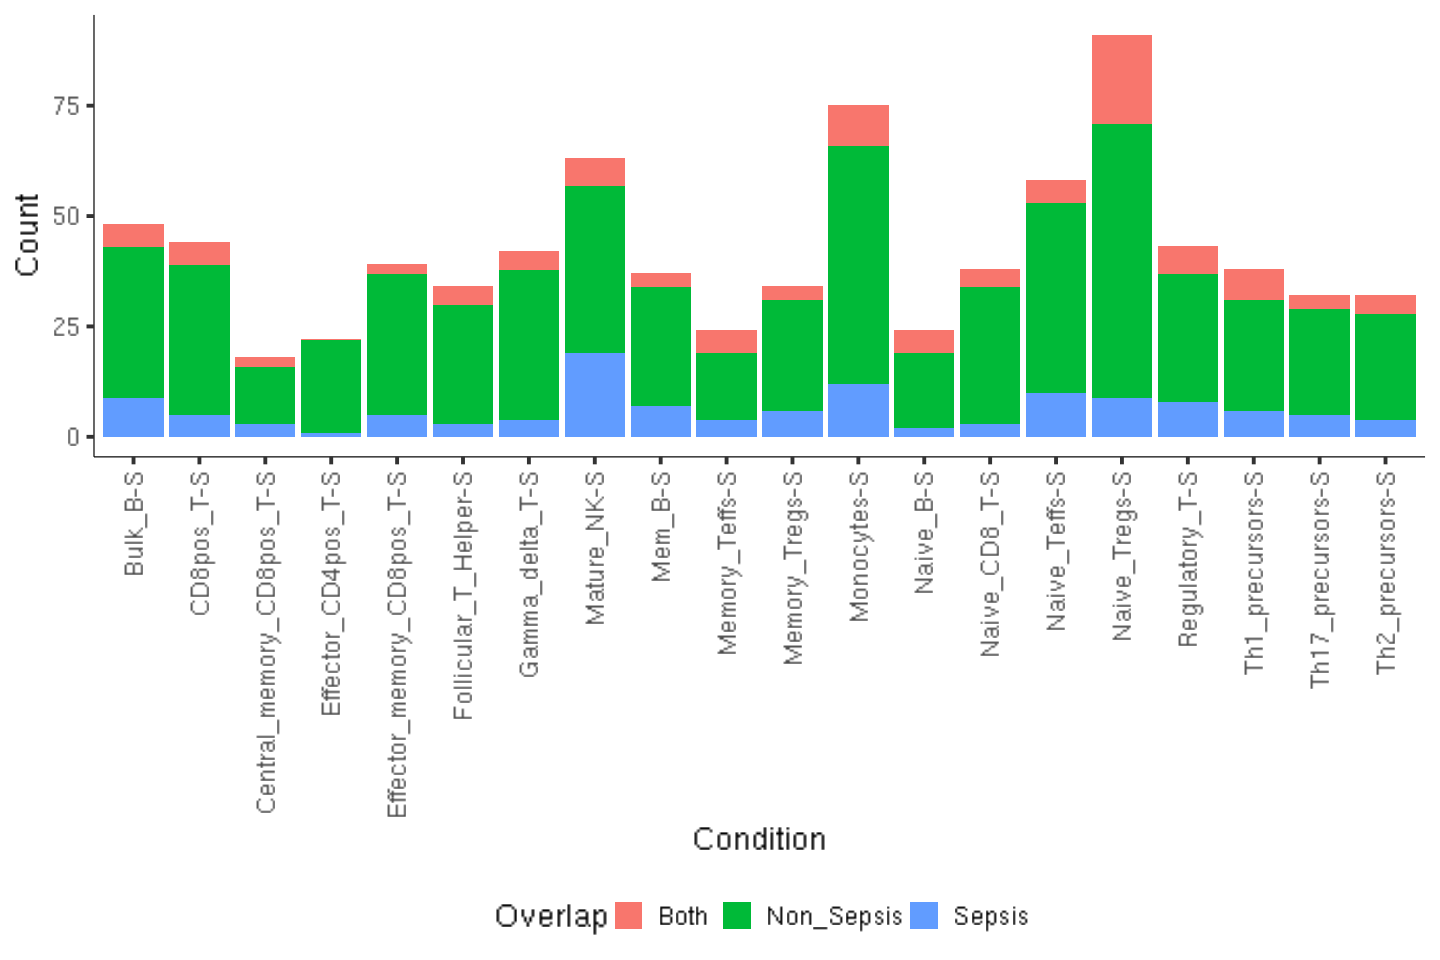

In [283]:
options(repr.plot.width=12, repr.plot.height=8)

plot.data %>%
    as.data.frame() %>%
    dplyr::mutate(Condition=colnames(stimulated.norm)) %>%
    tidyr::gather("Overlap", "Count", -Condition) %>%
    ggplot() +
    geom_bar(aes(x=Condition, y=Count, fill=Overlap), stat="identity") +
    ggplot_theme +
    theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5))